In [104]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.metrics import make_scorer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.model_selection import IterativeStratification
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit
from mlxtend.evaluate.time_series import plot_splits
from mlxtend.evaluate.time_series import print_cv_info
from mlxtend.evaluate.time_series import print_split_info
import lightgbm as lgb
import optuna
from functools import partial
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
import pickle
from scipy.sparse import issparse
import warnings
from collected_functions import *


Set base variable values

In [105]:
random_state = 42
np.random.seed(random_state)
cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': random_state}


Adjust Pandas settings to display more information before truncation.

In [106]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Load combined MA and DDS training data. We are using data generated from the previous multilabel classifcation model (which predicted ESFs) combined with user selections from our user interface to predict Assistance Requested (AR) topics based on the features state, region, designatedIncidentType, declarationType, and ESF(s).

In [107]:
df = pd.read_parquet('combined_training_set_nontime.parquet')
df['AR_topic'] = df['AR_topic'].astype(str)
df.rename(columns={'supportFunction': 'ESF'}, inplace=True)
print(df.shape)
df.head()

(6765, 22)


incidentId state  incidentTypeMA  region maType maPriority   ESF  agencyId  \
0  2024081901    CT    Severe Storm       1    FOS       High   5.0  DOI-USGS   
1  2024072801    FL  Tropical Storm       4    FOS     Normal   8.0        VA   
2  2024072801    FL  Tropical Storm       4    FOS     Normal   0.0        VA   
3  2024072801    FL  Tropical Storm       4    FOS     Normal   4.0   USDA-FS   
4  2024072801    FL  Tropical Storm       4    FOS     Normal  11.0  USDA-APH   

                 maId declarationType  \
0  3612EMCTDOI-USGS01              EM   
1        4806DRFLVA02              DR   
2        4806DRFLVA01              DR   
3   4806DRFLUSDA-FS01              DR   
4  4806DRFLUSDA-APH01              DR   

                                 assistanceRequested  \
0  USGS Field measurements of flood-water heights...   
1  Activate VHA OEM to NRCC ESF-8 PHMS. This is a...   
2  Activate VA to NRCC. This is a re-issuance of ...   
3  Activate USFS to the NRCC. This is a re-issuan...   
4  USDA liaison(s) to the NRCC, FEMA teams, or ot...   

                                     statementOfWork femaDeclarationString  \
0  As directed by and in coordination with FEMA, ...            EM-3612-CT   
1  As directed by and in coordination with FEMA a...            DR-4806-FL   
2  As directed by and in coordination with FEMA, ...            DR-4806-FL   
3  As directed by and in coordination with FEMA, ...            DR-4806-FL   
4  As directed by and in coordination with FEMA, ...            DR-4806-FL   

     incidentType         incidentBeginDate  fipsStateCode  \
0    Severe Storm 2024-08-18 00:00:00+00:00            9.0   
1  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   
2  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   
3  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   
4  Tropical Storm 2024-08-01 00:00:00+00:00           12.0   

            designatedIncidentTypes  \
0  Severe Storm,Flood,Mud/Landslide   
1          Hurricane,Tropical Storm   
2          Hurricane,Tropical Storm   
3          Hurricane,Tropical Storm   
4          Hurricane,Tropical Storm   

                                    declarationTitle    year  month   day  \
0  SEVERE STORMS, FLOODING, LANDSLIDES, AND MUDSL...  2024.0    8.0  18.0   
1                                    HURRICANE DEBBY  2024.0    8.0   1.0   
2                                    HURRICANE DEBBY  2024.0    8.0   1.0   
3                                    HURRICANE DEBBY  2024.0    8.0   1.0   
4                                    HURRICANE DEBBY  2024.0    8.0   1.0   

  AR_topic  
0       28  
1       23  
2       23  
3       30  
4       32

Transform the training data set using approach that is suitable for multiple categorical feature columns and a multilabel target. We return the transformers so that the test data set can be transformed later.

In [108]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'ESF',
    'year',
]

grouping_columns = [
    'incidentId',
    'state',
    'region',
    'year',
    'declarationType',
    'designatedIncidentTypes',
]

list_set_columns = [
    'ESF',
    'AR_topic',
]

target_column = 'AR_topic'

X_train, y_train = create_set_AR(
    df,
    grouping_columns,
    list_set_columns,
    feature_columns,
    target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(464, 7) 464
0                            [13]
1                            [13]
2                            [13]
3    [58, 87, 15, 118, 25, 62, 2]
4                    [100, 1, 47]
Name: AR_topic, dtype: object


incidentId state designatedIncidentTypes declarationType  region  \
0  2013020801    CT            Severe Storm              DR       1   
1  2013020801    NH            Severe Storm              DR       1   
2  2013020801    RI            Severe Storm              DR       1   
3  2013041203    ND                   Flood              EM       8   
4  2013041501    MA               Terrorist              EM       1   

                          ESF    year  
0                       [7.0]  2013.0  
1                       [7.0]  2013.0  
2                       [7.0]  2013.0  
3  [2.0, 3.0, 7.0, 9.0, 13.0]  2013.0  
4      [8.0, 1.0, 10.0, 13.0]  2013.0

In [109]:
# Check a known incidentId to verify our data is formatted as expected.
X_train[X_train['incidentId']==2024072801]

incidentId state                            designatedIncidentTypes  \
420  2024072801    SC                     Flood,Hurricane,Tropical Storm   
421  2024072801    VT                 Tropical Depression,Tropical Storm   
419  2024072801    SC             Flood,Tornado,Hurricane,Tropical Storm   
413  2024072801    FL                           Hurricane,Tropical Storm   
415  2024072801    GA                           Hurricane,Tropical Storm   
414  2024072801    FL  Coastal Storm,Tropical Storm,Severe Storm,Floo...   
416  2024072801    GA                           Hurricane,Tropical Storm   
417  2024072801    NC                                     Tropical Storm   
418  2024072801    PA                               Flood,Tropical Storm   

    declarationType  region  \
420              EM       4   
421              EM       1   
419              DR       4   
413              DR       4   
415              DR       4   
414              EM       4   
416              EM       4   
417              EM       4   
418              DR       3   

                                                   ESF    year  
420                                    [8.0, 3.0, 7.0]  2024.0  
421                                  [3.0, 11.0, 13.0]  2024.0  
419                                         [8.0, 3.0]  2024.0  
413  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0  
415                               [0.0, 9.0, 3.0, 4.0]  2024.0  
414  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0  
416                                         [0.0, 7.0]  2024.0  
417                                         [8.0, 7.0]  2024.0  
418                                              [7.0]  2024.0

In [110]:
y_train

0                              [13]
1                              [13]
2                              [13]
3      [58, 87, 15, 118, 25, 62, 2]
4                      [100, 1, 47]
                   ...             
462      [4, 1, 23, 80, 105, 38, 2]
455        [1, 23, 17, 108, 58, 38]
458                    [13, 12, 95]
457                            [14]
456     [17, 23, 1, 58, 105, 38, 2]
Name: AR_topic, Length: 464, dtype: object

In [111]:
# Verify that no row is missing an AR topic
y_train.isna().sum()

np.int64(0)

In [112]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [113]:
# Check a known incidentId to verify our data is formatted as expected.
X_train[X_train['incidentId']==2024072801]

incidentId state                            designatedIncidentTypes  \
420  2024072801    SC                 [Flood, Hurricane, Tropical Storm]   
421  2024072801    VT              [Tropical Depression, Tropical Storm]   
419  2024072801    SC        [Flood, Tornado, Hurricane, Tropical Storm]   
413  2024072801    FL                        [Hurricane, Tropical Storm]   
415  2024072801    GA                        [Hurricane, Tropical Storm]   
414  2024072801    FL  [Coastal Storm, Tropical Storm, Severe Storm, ...   
416  2024072801    GA                        [Hurricane, Tropical Storm]   
417  2024072801    NC                                   [Tropical Storm]   
418  2024072801    PA                            [Flood, Tropical Storm]   

    declarationType  region  \
420              EM       4   
421              EM       1   
419              DR       4   
413              DR       4   
415              DR       4   
414              EM       4   
416              EM       4   
417              EM       4   
418              DR       3   

                                                   ESF    year  
420                                    [8.0, 3.0, 7.0]  2024.0  
421                                  [3.0, 11.0, 13.0]  2024.0  
419                                         [8.0, 3.0]  2024.0  
413  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0  
415                               [0.0, 9.0, 3.0, 4.0]  2024.0  
414  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...  2024.0  
416                                         [0.0, 7.0]  2024.0  
417                                         [8.0, 7.0]  2024.0  
418                                              [7.0]  2024.0

In [114]:
# Since designatedIncidentTypes is a list it must be transformed differently than the other
# feature columns.
feature_columns_transform = [
    'state',
    'declarationType',
    'region',

]

X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes', 'ESF'],
    target_column,
    'cluster_'
)

In [115]:
X_train_transformed

state_AK  state_AL  state_AR  state_AS  state_AZ  state_CA  state_CO  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
462       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     state_CT  state_DC  state_DE  state_FL  state_GA  state_GU  state_HI  \
0         1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
462       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  state_LA  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
462       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       1.0       0.0   

     state_MA  state_MD  state_ME  state_MI  state_MN  state_MO  state_MP  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4         1.0       0.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
459       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
460       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
461       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
462       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
463       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

     state_MS  state_MT  state_NC  state_ND  state_NE  state_NH  state_NJ  \
0         0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       0.0       0.0       0.0       0.0       1.0       0.0   
2         0.0       0.0       0.0       0.0       0.0       0.0       0.0 

In [116]:
# Drop year and incidentId from X_train_transformed.
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)

print(X_train_transformed.shape)
X_train_transformed.head()

(464, 105)


state_AK  state_AL  state_AR  state_AS  state_AZ  state_CA  state_CO  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_CT  state_DC  state_DE  state_FL  state_GA  state_GU  state_HI  \
0       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  state_LA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_MA  state_MD  state_ME  state_MI  state_MN  state_MO  state_MP  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       1.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_MS  state_MT  state_NC  state_ND  state_NE  state_NH  state_NJ  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_NM  state_NV  state_NY  state_OH  state_OK  state_OR  state_PA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_PR  state_RI  state_SC  state_SD  state_TN  state_TX  state_UT  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_VA  state_VI  state_VT  state_WA  state_WI  state_WV  state_WY  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   declarationType_DR  declarationType_EM  region_1  region_2  region_3  \
0                 1.0                 0.0       1.0       0.0       0.0   
1                 1.0                 0.0       1.0       0.0       0.0   
2                 1.0                 0.0       1.0       0.0       0.0   
3                 0.0                 1.0       0.0       0.0       0.0   
4                 0.

In [117]:
X_train_transformed.columns.tolist()

['state_AK',
 'state_AL',
 'state_AR',
 'state_AS',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_GU',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MP',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_PR',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_VI',
 'state_VT',
 'state_WA',
 'state_WI',
 'state_WV',
 'state_WY',
 'declarationType_DR',
 'declarationType_EM',
 'region_1',
 'region_2',
 'region_3',
 'region_4',
 'region_5',
 'region_6',
 'region_7',
 'region_8',
 'region_9',
 'region_10',
 'designatedIncidentTypes_Biological',
 'designatedIncidentTypes_Chemical',
 'designatedInciden

In [118]:
print(y_train_transformed.shape)
y_train_transformed.head()

(464, 126)


cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0            0           0            0            0   
1            0            0           0            0            0   
2            0            0           0            0            0   
3            0            0           0            0            0   
4            0            0           0            0            0   

   cluster_112  cluster_113  cluster_114  cluster_115  cluster_116  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_117  cluster_118  cluster_119  cluster_12  cluster_120  \
0            0            0            0           0            0   
1            0            0            0           0            0   
2            0            0            0           0            0   
3            0            1            0           0            0   
4            0            0            0           0            0   

   cluster_121  cluster_122  cluster_123  cluster_124  cluster_125  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  cluster_18  \
0           1           0           0           0           0           0   
1           1           0           0           0           0           0   
2           1           0           0           0           0           0   
3           0           0           1           0           0           0   
4           0           0           0           0           0           0   

   cluster_19  cluster_2  cluster_20  cluster_21  cluster_22  cluster_23  \
0           0          0           0           0           0           0   
1           0          0           0           0           0           0   
2           0          0           0           0           0           0   
3           0          1           0           0           0           0   
4           0          0           0           0           0           0   

   cluster_24  cluster_25  cluster_26  cluster_27  cluster_28  cluster_29  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           1           0           0           0           0   
4           0           0           0           0           0           0   

   cluster_3  cluster_30  cluster_31  cluster_32  cluster_

In [119]:
y_train_transformed.isna().sum().sum()

np.int64(0)

In [120]:
y_train_transformed.columns.tolist()

['cluster_0',
 'cluster_1',
 'cluster_10',
 'cluster_100',
 'cluster_101',
 'cluster_102',
 'cluster_103',
 'cluster_104',
 'cluster_105',
 'cluster_106',
 'cluster_107',
 'cluster_108',
 'cluster_109',
 'cluster_11',
 'cluster_110',
 'cluster_111',
 'cluster_112',
 'cluster_113',
 'cluster_114',
 'cluster_115',
 'cluster_116',
 'cluster_117',
 'cluster_118',
 'cluster_119',
 'cluster_12',
 'cluster_120',
 'cluster_121',
 'cluster_122',
 'cluster_123',
 'cluster_124',
 'cluster_125',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_2',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'cluster_3',
 'cluster_30',
 'cluster_31',
 'cluster_32',
 'cluster_33',
 'cluster_34',
 'cluster_35',
 'cluster_36',
 'cluster_37',
 'cluster_38',
 'cluster_39',
 'cluster_4',
 'cluster_40',
 'cluster_41',
 'cluster_42',
 'cluster_43',
 'cl

Run a variety of machine learning models and base classifiers using cross validation for model selection purposes. We are using RandomForestClassifier instead of SVC in this case as we have a very sparse target dataset.

In [122]:
base_rf = RandomForestClassifier(
        random_state=random_state,
        n_jobs=-1,
        max_depth=12,
        n_estimators=100,
        )
base_xgb = XGBClassifier(
        max_depth=12,
        random_state=random_state,
        n_estimators=100,
        base_score=0.5,
        n_jobs=-1,
        )
base_gnb = GaussianNB()

br_classifier_rf = BinaryRelevance(
    classifier = base_rf,
    require_dense = [True, True]
)
br_classifier_xgb = BinaryRelevance(
    classifier = base_xgb,
    require_dense = [True, True]
)
br_classifier_gnb = BinaryRelevance(
    classifier = base_gnb,
    require_dense = [True, True]
)

cc_classifier_rf = ClassifierChain(
    classifier=base_rf, 
    require_dense=[True, True],
)
cc_classifier_xgb = ClassifierChain(
    classifier=base_xgb,
    require_dense=[True, True],
)
cc_classifier_gnb = ClassifierChain(
    classifier=base_gnb,
    require_dense=[True, True],
)

# Check performance of sklearn models that can natively handle multiclass targets.
base_rf = RandomForestClassifier(
    random_state=random_state,
    n_jobs=-1,
    max_depth=12,
    n_estimators=100,
    class_weight='balanced_subsample'
)

base_etc = ExtraTreesClassifier(
    random_state=random_state,
    max_depth=12,
    n_jobs=-1,
    class_weight='balanced_subsample',
)

# Finish with sklearn models that require a base estimator.
moc_rf = MultiOutputClassifier(estimator=base_rf)
moc_xgb = MultiOutputClassifier(estimator=base_xgb)
moc_gnb = MultiOutputClassifier(estimator=base_gnb)

ovr_rf = OneVsRestClassifier(estimator=base_rf)
ovr_xgb = OneVsRestClassifier(estimator=base_xgb)
ovr_gnb = OneVsRestClassifier(estimator=base_gnb)

dummy = OneVsRestClassifier(DummyClassifier(strategy="stratified", random_state=random_state))

clf_list = [
    br_classifier_rf,
    br_classifier_xgb,
    br_classifier_gnb,
    cc_classifier_rf,
    cc_classifier_xgb,
    cc_classifier_gnb,
    base_rf,
    base_etc,
    moc_rf,
    moc_xgb,
    moc_gnb,
    ovr_rf,
    ovr_xgb,
    ovr_gnb,
    dummy,
]

hamming_scorer = make_scorer(
    hamming_loss,
    greater_is_better=False, 
)

F1_Macro_Avg = make_scorer(
    f1_score,
    average='macro', 
    zero_division=1,
)

F1_Samples_Avg = make_scorer(
    f1_score,
    average='samples', 
    zero_division=1,
)

# include mAP with the understanding that some of our models output sparse arrays which
# does not work in our scoring setup using cross_validate.
mean_average_precision = make_scorer(
    average_precision_score,
    average='macro', 
)

scoring = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
    'mAP':mean_average_precision,
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list:
        cross_val_results = cross_validate(clf,
                                        X=X_train_transformed,
                                        y=y_train_transformed,
                                        cv=5,
                                        scoring=scoring,
                                        n_jobs=-1,
                                        )

        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

BinaryRelevance(classifier=RandomForestClassifier(max_depth=12, n_jobs=-1,
                                                  random_state=42),
                require_dense=[True, True])
Mean Hamming: -0.05771499810770497, 0.012973509589982753

Mean F1 Macro Avg: 0.31930375233078, 0.08741840419210434

Mean F1 Samples Avg: 0.20203892645873966, 0.04276233759262183

Mean Average Precision Avg: nan, nan
BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
              

XGBoost appears to be our best base model. RandomForestClassifier is responding similarly but just a bit worse. The most promising models again appear to be BinaryRelevance, ClassifierChain, and OneVsRestClassifier (MultiOutputClassification had similar results but based on findings OneVsRestClassifier is supposed to be better suited to this sort of task per documentation).

The standalone RandomForestClassifier and ExtraTreesClassifier do not perform nearly as well as the more specialized models from skmultilearn. We will not move forward with them.

We can start with hyperparameter tuning of BinaryRelevance and the XGBoost base classifier.

In [ ]:
def objective_brxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': 1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'tree_method': 'hist',
    }

    base_XGB = XGBClassifier(**xgb_params)
    
    clf = BinaryRelevance(
        classifier = base_XGB,
        require_dense = [True, True],
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_brxgb = partial(objective_brxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state = random_state,
                        )

# Maximize the score to improve results
study_brxgb = optuna.create_study(direction="maximize")

study_brxgb.optimize(objective_brxgb, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_brxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_brxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-27 09:41:12,936] A new study created in memory with name: no-name-92a1717f-8653-4733-ba28-1dc934e0b06c
Best trial: 0. Best value: 1.09562:   2%|▏         | 1/60 [00:33<32:48, 33.36s/it]

[I 2025-11-27 09:41:46,291] Trial 0 finished with value: 1.0956196309273927 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0679212630931199, 'subsample': 0.9364057869294813, 'colsample_bytree': 0.6320084234900178, 'scale_pos_weight': 4.932993742819454}. Best is trial 0 with value: 1.0956196309273927.


Best trial: 1. Best value: 1.11782:   3%|▎         | 2/60 [01:44<53:59, 55.86s/it]

[I 2025-11-27 09:42:57,901] Trial 1 finished with value: 1.1178182679946138 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01052230550623338, 'subsample': 0.8036455539935897, 'colsample_bytree': 0.8117160395235006, 'scale_pos_weight': 3.8176384043151694}. Best is trial 1 with value: 1.1178182679946138.


Best trial: 1. Best value: 1.11782:   5%|▌         | 3/60 [02:25<46:17, 48.73s/it]

[I 2025-11-27 09:43:38,155] Trial 2 finished with value: 1.0790177959527716 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.019666747995423072, 'subsample': 0.733389416045977, 'colsample_bytree': 0.8603925158502792, 'scale_pos_weight': 2.5764766565704567}. Best is trial 1 with value: 1.1178182679946138.


Best trial: 1. Best value: 1.11782:   7%|▋         | 4/60 [03:06<42:34, 45.62s/it]

[I 2025-11-27 09:44:18,999] Trial 3 finished with value: 0.9613668073073643 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.009151974511936544, 'subsample': 0.6323123201124023, 'colsample_bytree': 0.7149694964031564, 'scale_pos_weight': 2.062547575721631}. Best is trial 1 with value: 1.1178182679946138.


Best trial: 4. Best value: 1.12141:   8%|▊         | 5/60 [04:05<46:30, 50.74s/it]

[I 2025-11-27 09:45:18,834] Trial 4 finished with value: 1.1214070448672846 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.007046980682586694, 'subsample': 0.7042032125967941, 'colsample_bytree': 0.8902919730816506, 'scale_pos_weight': 4.774186258899862}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  10%|█         | 6/60 [04:53<44:35, 49.55s/it]

[I 2025-11-27 09:46:06,052] Trial 5 finished with value: 1.086746909532297 and parameters: {'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.0003229989306205563, 'subsample': 0.8123295185146509, 'colsample_bytree': 0.8539265271438605, 'scale_pos_weight': 4.698702089947451}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  12%|█▏        | 7/60 [05:15<36:00, 40.77s/it]

[I 2025-11-27 09:46:28,765] Trial 6 finished with value: 1.0511114657481566 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.00029196791745026964, 'subsample': 0.617588646046664, 'colsample_bytree': 0.9329058156963685, 'scale_pos_weight': 4.501268669102496}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  13%|█▎        | 8/60 [05:51<33:57, 39.19s/it]

[I 2025-11-27 09:47:04,560] Trial 7 finished with value: 1.0818496239538604 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.001242601856489101, 'subsample': 0.8253076709763811, 'colsample_bytree': 0.9278093033868862, 'scale_pos_weight': 3.4499305072455426}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  15%|█▌        | 9/60 [06:34<34:14, 40.29s/it]

[I 2025-11-27 09:47:47,277] Trial 8 finished with value: 0.9278341616480562 and parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.00016770285432710243, 'subsample': 0.6187478380132275, 'colsample_bytree': 0.82852166141582, 'scale_pos_weight': 2.1512487491162915}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  17%|█▋        | 10/60 [06:54<28:29, 34.19s/it]

[I 2025-11-27 09:48:07,819] Trial 9 finished with value: 0.9842889665973666 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.01451012908667918, 'subsample': 0.6021596137860867, 'colsample_bytree': 0.7852975017695807, 'scale_pos_weight': 2.529821806465973}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  18%|█▊        | 11/60 [07:59<35:34, 43.57s/it]

[I 2025-11-27 09:49:12,650] Trial 10 finished with value: 1.10845467106459 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.0019062190486786369, 'subsample': 0.7086689409059282, 'colsample_bytree': 0.698504235774605, 'scale_pos_weight': 5.984723871957858}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  20%|██        | 12/60 [09:12<41:59, 52.49s/it]

[I 2025-11-27 09:50:25,531] Trial 11 finished with value: 1.1117625754926563 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.005235533852431075, 'subsample': 0.8560217491148764, 'colsample_bytree': 0.8835445530234315, 'scale_pos_weight': 3.7920643455348664}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  22%|██▏       | 13/60 [10:04<40:57, 52.28s/it]

[I 2025-11-27 09:51:17,332] Trial 12 finished with value: 1.0895523628414971 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.050870077370751346, 'subsample': 0.719433255568709, 'colsample_bytree': 0.785289622774691, 'scale_pos_weight': 5.32049883909549}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  23%|██▎       | 14/60 [10:52<39:00, 50.87s/it]

[I 2025-11-27 09:52:04,961] Trial 13 finished with value: 1.0736455647954186 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0027696637653772376, 'subsample': 0.7651470729149138, 'colsample_bytree': 0.7348882553436608, 'scale_pos_weight': 3.283888409385458}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  25%|██▌       | 15/60 [11:52<40:15, 53.69s/it]

[I 2025-11-27 09:53:05,168] Trial 14 finished with value: 1.100130930203827 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.026585472899209393, 'subsample': 0.9002062913771299, 'colsample_bytree': 0.8191726949442345, 'scale_pos_weight': 4.2166120361690025}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  27%|██▋       | 16/60 [12:51<40:41, 55.49s/it]

[I 2025-11-27 09:54:04,837] Trial 15 finished with value: 1.1013854096736544 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.0007731472899573442, 'subsample': 0.6630139944783391, 'colsample_bytree': 0.9110312085504128, 'scale_pos_weight': 5.703651296124842}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  28%|██▊       | 17/60 [13:57<42:01, 58.65s/it]

[I 2025-11-27 09:55:10,834] Trial 16 finished with value: 1.0870328656953798 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.005644581751179667, 'subsample': 0.6798188294024694, 'colsample_bytree': 0.8869626682234352, 'scale_pos_weight': 3.8805685810810338}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  30%|███       | 18/60 [14:56<41:04, 58.68s/it]

[I 2025-11-27 09:56:09,595] Trial 17 finished with value: 1.0733511530039344 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.006486135457383169, 'subsample': 0.8006227908320191, 'colsample_bytree': 0.7510296664905974, 'scale_pos_weight': 3.1251785651240978}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  32%|███▏      | 19/60 [15:57<40:32, 59.32s/it]

[I 2025-11-27 09:57:10,396] Trial 18 finished with value: 1.0986622629584595 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.028946302594069027, 'subsample': 0.7573091457989201, 'colsample_bytree': 0.8186347039567675, 'scale_pos_weight': 5.208233457979218}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  33%|███▎      | 20/60 [16:40<36:20, 54.50s/it]

[I 2025-11-27 09:57:53,676] Trial 19 finished with value: 1.0635399889561548 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.0907712011107159, 'subsample': 0.8533412955655254, 'colsample_bytree': 0.6482390579831983, 'scale_pos_weight': 4.284494633539267}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  35%|███▌      | 21/60 [17:11<30:50, 47.45s/it]

[I 2025-11-27 09:58:24,696] Trial 20 finished with value: 1.0941342067352473 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.011841594697264464, 'subsample': 0.6765431689512885, 'colsample_bytree': 0.9440681369897077, 'scale_pos_weight': 3.6813193313867947}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  37%|███▋      | 22/60 [18:25<35:08, 55.49s/it]

[I 2025-11-27 09:59:38,921] Trial 21 finished with value: 1.1073795496926309 and parameters: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.004881654723566056, 'subsample': 0.8672672136352866, 'colsample_bytree': 0.8821586309631244, 'scale_pos_weight': 3.936908635758296}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 4. Best value: 1.12141:  38%|███▊      | 23/60 [19:32<36:18, 58.88s/it]

[I 2025-11-27 10:00:45,713] Trial 22 finished with value: 1.0838100942059603 and parameters: {'n_estimators': 275, 'max_depth': 11, 'learning_rate': 0.003351536498566129, 'subsample': 0.8619940776028013, 'colsample_bytree': 0.8967470503004138, 'scale_pos_weight': 3.004193991676421}. Best is trial 4 with value: 1.1214070448672846.


Best trial: 23. Best value: 1.12384:  40%|████      | 24/60 [20:38<36:38, 61.06s/it]

[I 2025-11-27 10:01:51,845] Trial 23 finished with value: 1.1238400769742327 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.008444142229880132, 'subsample': 0.7787537786250818, 'colsample_bytree': 0.8525242655180313, 'scale_pos_weight': 4.74915177488552}. Best is trial 23 with value: 1.1238400769742327.


Best trial: 23. Best value: 1.12384:  42%|████▏     | 25/60 [21:32<34:15, 58.74s/it]

[I 2025-11-27 10:02:45,166] Trial 24 finished with value: 1.101476739308194 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.038084522896877165, 'subsample': 0.7847823728564883, 'colsample_bytree': 0.8540784937681969, 'scale_pos_weight': 4.907831869150815}. Best is trial 23 with value: 1.1238400769742327.


Best trial: 23. Best value: 1.12384:  43%|████▎     | 26/60 [22:20<31:25, 55.46s/it]

[I 2025-11-27 10:03:32,990] Trial 25 finished with value: 1.113180515057723 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.008966977513069505, 'subsample': 0.7448885072344447, 'colsample_bytree': 0.7996506095707667, 'scale_pos_weight': 4.361050346669759}. Best is trial 23 with value: 1.1238400769742327.


Best trial: 26. Best value: 1.14762:  45%|████▌     | 27/60 [23:16<30:43, 55.85s/it]

[I 2025-11-27 10:04:29,756] Trial 26 finished with value: 1.147623622435059 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.016056333446858164, 'subsample': 0.7804332464570441, 'colsample_bytree': 0.8393858695558899, 'scale_pos_weight': 5.3895740092646545}. Best is trial 26 with value: 1.147623622435059.


Best trial: 27. Best value: 1.15799:  47%|████▋     | 28/60 [23:54<26:55, 50.49s/it]

[I 2025-11-27 10:05:07,740] Trial 27 finished with value: 1.1579889079455783 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.022286378112510278, 'subsample': 0.7046832765331827, 'colsample_bytree': 0.847017393240107, 'scale_pos_weight': 5.436567893383895}. Best is trial 27 with value: 1.1579889079455783.


Best trial: 28. Best value: 1.16187:  48%|████▊     | 29/60 [24:25<23:03, 44.62s/it]

[I 2025-11-27 10:05:38,653] Trial 28 finished with value: 1.1618724045891236 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.01923773064614664, 'subsample': 0.7824246667072936, 'colsample_bytree': 0.8427275790972413, 'scale_pos_weight': 5.462537870107027}. Best is trial 28 with value: 1.1618724045891236.


Best trial: 28. Best value: 1.16187:  50%|█████     | 30/60 [24:53<19:49, 39.64s/it]

[I 2025-11-27 10:06:06,663] Trial 29 finished with value: 1.1358762023301645 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05807018332176152, 'subsample': 0.9380535622054249, 'colsample_bytree': 0.8367330086642155, 'scale_pos_weight': 5.413193612985963}. Best is trial 28 with value: 1.1618724045891236.


Best trial: 30. Best value: 1.16634:  52%|█████▏    | 31/60 [25:27<18:17, 37.85s/it]

[I 2025-11-27 10:06:40,336] Trial 30 finished with value: 1.1663420525445123 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.0184998479200408, 'subsample': 0.8261331478925287, 'colsample_bytree': 0.7587035091711336, 'scale_pos_weight': 5.62170997963114}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  53%|█████▎    | 32/60 [26:00<17:00, 36.44s/it]

[I 2025-11-27 10:07:13,505] Trial 31 finished with value: 1.164758607097261 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.020262035025481913, 'subsample': 0.8321932405277574, 'colsample_bytree': 0.7509277922399227, 'scale_pos_weight': 5.682076542482384}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  55%|█████▌    | 33/60 [26:34<16:05, 35.76s/it]

[I 2025-11-27 10:07:47,679] Trial 32 finished with value: 1.1612592458620445 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.02486564062195006, 'subsample': 0.8936916953426429, 'colsample_bytree': 0.7576309864525286, 'scale_pos_weight': 5.7043813280565185}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  57%|█████▋    | 34/60 [27:07<15:04, 34.80s/it]

[I 2025-11-27 10:08:20,246] Trial 33 finished with value: 1.093196920372305 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.08590914301319891, 'subsample': 0.9069538261902731, 'colsample_bytree': 0.748462320639932, 'scale_pos_weight': 5.7990873347907606}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  58%|█████▊    | 35/60 [27:40<14:17, 34.31s/it]

[I 2025-11-27 10:08:53,392] Trial 34 finished with value: 1.1303866969083194 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.04037751462262411, 'subsample': 0.8308255789682978, 'colsample_bytree': 0.6683942941654984, 'scale_pos_weight': 5.115578765752638}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  60%|██████    | 36/60 [28:11<13:17, 33.22s/it]

[I 2025-11-27 10:09:24,083] Trial 35 finished with value: 1.1633581263950337 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.017644425268601518, 'subsample': 0.8934760489490213, 'colsample_bytree': 0.7636958029375355, 'scale_pos_weight': 5.670339166130693}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  62%|██████▏   | 37/60 [28:34<11:36, 30.29s/it]

[I 2025-11-27 10:09:47,524] Trial 36 finished with value: 1.1609365857454086 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.016657386543309144, 'subsample': 0.8373196777416209, 'colsample_bytree': 0.6022264495503133, 'scale_pos_weight': 5.937675293306192}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  63%|██████▎   | 38/60 [29:06<11:14, 30.66s/it]

[I 2025-11-27 10:10:19,059] Trial 37 finished with value: 1.139118685451828 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.03387178019699861, 'subsample': 0.9202009784523375, 'colsample_bytree': 0.7120431548446189, 'scale_pos_weight': 5.58449893056655}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  65%|██████▌   | 39/60 [29:29<10:01, 28.62s/it]

[I 2025-11-27 10:10:42,912] Trial 38 finished with value: 1.117334960839463 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05901634514200196, 'subsample': 0.8796193736840234, 'colsample_bytree': 0.769563985527001, 'scale_pos_weight': 5.015746876518595}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  67%|██████▋   | 40/60 [29:59<09:35, 28.76s/it]

[I 2025-11-27 10:11:12,004] Trial 39 finished with value: 1.1566095174041346 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.013019769594923545, 'subsample': 0.8072672742593772, 'colsample_bytree': 0.7233176682712096, 'scale_pos_weight': 5.671372094170883}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  68%|██████▊   | 41/60 [30:20<08:24, 26.55s/it]

[I 2025-11-27 10:11:33,393] Trial 40 finished with value: 1.1397068271618072 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01866784166360031, 'subsample': 0.8438355217619841, 'colsample_bytree': 0.6907376112298634, 'scale_pos_weight': 5.15361864384467}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  70%|███████   | 42/60 [30:54<08:35, 28.65s/it]

[I 2025-11-27 10:12:06,944] Trial 41 finished with value: 1.1633858340843943 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.023390807919843423, 'subsample': 0.8854280789057594, 'colsample_bytree': 0.7638862596194878, 'scale_pos_weight': 5.867469333396457}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  72%|███████▏  | 43/60 [31:28<08:34, 30.26s/it]

[I 2025-11-27 10:12:40,953] Trial 42 finished with value: 1.1445391415105373 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.04426840007843262, 'subsample': 0.949172457939771, 'colsample_bytree': 0.7977841521438906, 'scale_pos_weight': 5.991808807195459}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  73%|███████▎  | 44/60 [32:01<08:19, 31.25s/it]

[I 2025-11-27 10:13:14,502] Trial 43 finished with value: 1.1611133851776707 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.009508580487309536, 'subsample': 0.8835464430007609, 'colsample_bytree': 0.7710568780543309, 'scale_pos_weight': 5.570387750592674}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  75%|███████▌  | 45/60 [32:32<07:49, 31.28s/it]

[I 2025-11-27 10:13:45,854] Trial 44 finished with value: 1.1572252376402299 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.02254596905309527, 'subsample': 0.819604611603235, 'colsample_bytree': 0.7995269324540503, 'scale_pos_weight': 5.823529653176413}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  77%|███████▋  | 46/60 [33:06<07:28, 32.07s/it]

[I 2025-11-27 10:14:19,764] Trial 45 finished with value: 1.165995985166863 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01414246336500604, 'subsample': 0.7987073858784632, 'colsample_bytree': 0.7365531004664652, 'scale_pos_weight': 5.519266311500848}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  78%|███████▊  | 47/60 [33:48<07:34, 34.95s/it]

[I 2025-11-27 10:15:01,454] Trial 46 finished with value: 1.110419424576003 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.003804168729134964, 'subsample': 0.7994656979581123, 'colsample_bytree': 0.7420128970807021, 'scale_pos_weight': 4.918984718127113}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  80%|████████  | 48/60 [34:29<07:22, 36.88s/it]

[I 2025-11-27 10:15:42,838] Trial 47 finished with value: 1.144412832846696 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.013881241448552288, 'subsample': 0.9203563096681677, 'colsample_bytree': 0.7298589255753309, 'scale_pos_weight': 4.621821310740132}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  82%|████████▏ | 49/60 [34:43<05:29, 30.00s/it]

[I 2025-11-27 10:15:56,776] Trial 48 finished with value: 1.134312862798773 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.00010153232605974164, 'subsample': 0.8774018937591497, 'colsample_bytree': 0.7029696841202211, 'scale_pos_weight': 5.8503474888878735}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  83%|████████▎ | 50/60 [35:07<04:40, 28.01s/it]

[I 2025-11-27 10:16:20,152] Trial 49 finished with value: 1.1567427225616662 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.03092918309415362, 'subsample': 0.8464770155109826, 'colsample_bytree': 0.7587610300442088, 'scale_pos_weight': 5.252673592668029}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  85%|████████▌ | 51/60 [35:44<04:36, 30.73s/it]

[I 2025-11-27 10:16:57,233] Trial 50 finished with value: 1.1222141093573614 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.002204470003727567, 'subsample': 0.825528829853266, 'colsample_bytree': 0.6866419253296991, 'scale_pos_weight': 5.561521040059662}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  87%|████████▋ | 52/60 [36:18<04:13, 31.66s/it]

[I 2025-11-27 10:17:31,054] Trial 51 finished with value: 1.1626011428319858 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0187829266322386, 'subsample': 0.7955349662307708, 'colsample_bytree': 0.7796909231168476, 'scale_pos_weight': 5.467546657494978}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  88%|████████▊ | 53/60 [37:00<04:03, 34.81s/it]

[I 2025-11-27 10:18:13,212] Trial 52 finished with value: 1.161558737474634 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.007225381895047848, 'subsample': 0.7917207474445339, 'colsample_bytree': 0.7828474657343423, 'scale_pos_weight': 5.762560737785551}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  90%|█████████ | 54/60 [37:34<03:28, 34.70s/it]

[I 2025-11-27 10:18:47,669] Trial 53 finished with value: 1.1513168707034223 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.011066160377123189, 'subsample': 0.8170114040584061, 'colsample_bytree': 0.7686771175644072, 'scale_pos_weight': 5.29938552674474}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  92%|█████████▏| 55/60 [38:14<03:00, 36.12s/it]

[I 2025-11-27 10:19:27,084] Trial 54 finished with value: 1.1222016435332731 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.0007955405020233374, 'subsample': 0.7629131436520377, 'colsample_bytree': 0.725108472238773, 'scale_pos_weight': 5.59266426528599}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  93%|█████████▎| 56/60 [38:48<02:22, 35.56s/it]

[I 2025-11-27 10:20:01,329] Trial 55 finished with value: 1.1164094122429948 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.027657233061517215, 'subsample': 0.7373948847000973, 'colsample_bytree': 0.737143809496008, 'scale_pos_weight': 5.898960142690518}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  95%|█████████▌| 57/60 [39:21<01:44, 34.91s/it]

[I 2025-11-27 10:20:34,744] Trial 56 finished with value: 1.1607219972308787 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.015090353942782141, 'subsample': 0.8711075805806875, 'colsample_bytree': 0.7867475785555298, 'scale_pos_weight': 5.468016773144359}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  97%|█████████▋| 58/60 [39:55<01:09, 34.53s/it]

[I 2025-11-27 10:21:08,381] Trial 57 finished with value: 1.114071579851673 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.06827580289675002, 'subsample': 0.9154869774150726, 'colsample_bytree': 0.807514133516659, 'scale_pos_weight': 5.05481568638158}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634:  98%|█████████▊| 59/60 [40:47<00:39, 39.84s/it]

[I 2025-11-27 10:22:00,619] Trial 58 finished with value: 1.1204517893841355 and parameters: {'n_estimators': 225, 'max_depth': 14, 'learning_rate': 0.011281133011792429, 'subsample': 0.892930787491565, 'colsample_bytree': 0.7558355533552419, 'scale_pos_weight': 5.234238653143737}. Best is trial 30 with value: 1.1663420525445123.


Best trial: 30. Best value: 1.16634: 100%|██████████| 60/60 [41:14<00:00, 41.25s/it]

[I 2025-11-27 10:22:27,777] Trial 59 finished with value: 1.130748368796306 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.045101065191422055, 'subsample': 0.8616944295008082, 'colsample_bytree': 0.7813858932271185, 'scale_pos_weight': 5.666093883998054}. Best is trial 30 with value: 1.1663420525445123.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.1663
Best Parameters:
  n_estimators: 175
  max_depth: 5
  learning_rate: 0.0184998479200408
  subsample: 0.8261331478925287
  colsample_bytree: 0.7587035091711336
  scale_pos_weight: 5.62170997963114


In [ ]:
study_brxgb_best_params = study_brxgb.best_params

study_brxgb_best_params_xgb = {
    'n_estimators': study_brxgb_best_params['n_estimators'],
    'max_depth': study_brxgb_best_params['max_depth'],
    'learning_rate': study_brxgb_best_params['learning_rate'],
    'subsample': study_brxgb_best_params['subsample'],
    'colsample_bytree' : study_brxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_brxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': -1,
}

study_brxgb_base_xgb = XGBClassifier(**study_brxgb_best_params_xgb)
study_brxgb_tuned = BinaryRelevance(
    classifier = study_brxgb_base_xgb,
    require_dense = [True, True]
)

study_brxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = study_brxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br)

display_error_heatmap(y_train_transformed, y_pred_training_br)

display_label_cardinality_error(y_train_transformed, y_pred_training_br)

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


We see some rows with false positives in the error heatmap along with a pleasant amount of true positives and true negatives. Overall, this is performing better than our initial model predicting ESFs did, and that had far fewer labels for the target. However, this time we do have far more features with the inclusion of ESFs in the training set.

The ClassifierChain we started with used a base order for the labels. We can try to improve the outcome using correlation-based ordering.

In [ ]:
# Make sure we have a type that works for our needs.
if isinstance(y_train_transformed, np.ndarray):
    Y_df = pd.DataFrame(y_train_transformed, columns=list(range(y_train_transformed.shape[1])))
else:
    Y_df = y_train_transformed.copy()
    Y_df.columns = list(range(Y_df.shape[1]))

# Assign label orders via correlation measures
correlation_matrix = Y_df.corr() 
num_labels = correlation_matrix.shape[0]
label_indices = list(range(num_labels))

total_correlations = correlation_matrix.abs().sum(axis=1)
start_label = total_correlations.idxmax()
ordered_labels = [start_label]
remaining_labels = set(label_indices) - {start_label}

while remaining_labels:
    best_next_label = -1
    max_avg_corr = -1

    for candidate_label in remaining_labels:
        # Calculate the absolute correlation between the candidate and all chosen labels
        corrs_with_chosen = correlation_matrix.loc[candidate_label, ordered_labels].abs()
        
        # Calculate the average (or sum) of these correlations
        avg_corr = corrs_with_chosen.mean() 

        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            best_next_label = candidate_label

    # Add the best label to the order and remove it from the remaining set
    if best_next_label != -1:
        ordered_labels.append(best_next_label)
        remaining_labels.remove(best_next_label)
    else:
        # Should not happen if the correlation matrix is correctly defined
        break

# The final result is the desired order for the ClassifierChain
final_chain_order = ordered_labels
print(f"Optimal ClassifierChain Order: {final_chain_order}")

Optimal ClassifierChain Order: [np.int64(109), 30, 9, 67, 90, 12, 75, 44, 92, 48, 34, 39, 95, 65, 29, 16, 61, 85, 106, 60, 35, 41, 73, 27, 125, 55, 121, 116, 50, 28, 80, 36, 42, 57, 1, 38, 7, 21, 56, 62, 45, 2, 104, 52, 83, 47, 110, 58, 54, 24, 37, 101, 72, 63, 120, 53, 68, 43, 11, 8, 91, 105, 86, 49, 117, 87, 33, 74, 112, 76, 66, 10, 96, 102, 70, 115, 4, 123, 97, 69, 79, 6, 78, 114, 103, 40, 84, 113, 82, 108, 88, 111, 64, 99, 93, 94, 98, 0, 59, 13, 119, 46, 107, 15, 122, 19, 20, 25, 17, 71, 89, 81, 32, 23, 118, 77, 14, 22, 51, 18, 31, 3, 5, 100, 26, 124]


In [ ]:
def objective_ccxgb(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())

        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb = partial(objective_ccxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=final_chain_order,
                        random_state=random_state,
                        )

study_ccxgb = optuna.create_study(direction="maximize")

study_ccxgb.optimize(objective_ccxgb, n_trials=5, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-27 10:30:00,486] A new study created in memory with name: no-name-d620b6f5-e0dd-4139-af94-40d8b35f821f
Best trial: 0. Best value: 0.283266:  20%|██        | 1/5 [01:44<06:57, 104.47s/it]

[I 2025-11-27 10:31:44,956] Trial 0 finished with value: 0.2832659389316019 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.005519863524520566, 'subsample': 0.6573503200630669, 'colsample_bytree': 0.6847086269951802, 'scale_pos_weight': 4.9770671904079835}. Best is trial 0 with value: 0.2832659389316019.


Best trial: 1. Best value: 0.283485:  40%|████      | 2/5 [02:35<03:39, 73.18s/it] 

[I 2025-11-27 10:32:36,225] Trial 1 finished with value: 0.28348455099632996 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.004723287403997393, 'subsample': 0.8250824106674806, 'colsample_bytree': 0.8375995121242106, 'scale_pos_weight': 3.895203072261948}. Best is trial 1 with value: 0.28348455099632996.


Best trial: 1. Best value: 0.283485:  60%|██████    | 3/5 [03:37<02:15, 67.78s/it]

[I 2025-11-27 10:33:37,582] Trial 2 finished with value: 0.2601952602692355 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.03025614795964651, 'subsample': 0.7158004434231064, 'colsample_bytree': 0.8575570480115695, 'scale_pos_weight': 5.657618109063503}. Best is trial 1 with value: 0.28348455099632996.


Best trial: 3. Best value: 0.289873:  80%|████████  | 4/5 [04:00<00:50, 50.41s/it]

[I 2025-11-27 10:34:01,357] Trial 3 finished with value: 0.28987276401253015 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.00014982149537985981, 'subsample': 0.8172807127841486, 'colsample_bytree': 0.7842593821976573, 'scale_pos_weight': 5.854587144705757}. Best is trial 3 with value: 0.28987276401253015.


Best trial: 3. Best value: 0.289873: 100%|██████████| 5/5 [04:56<00:00, 59.24s/it]

[I 2025-11-27 10:34:56,698] Trial 4 finished with value: 0.28689424253394924 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.0004954628734202216, 'subsample': 0.6247842252464197, 'colsample_bytree': 0.6705351832957425, 'scale_pos_weight': 4.0452615758488895}. Best is trial 3 with value: 0.28987276401253015.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.2899
Best Parameters:
  n_estimators: 50
  max_depth: 5
  learning_rate: 0.00014982149537985981
  subsample: 0.8172807127841486
  colsample_bytree: 0.7842593821976573
  scale_pos_weight: 5.854587144705757


The results were far worse than the BinaryRelevance model so we purposefully limited the number of trials for the sake of brevity.

In [ ]:
study_ccxgb_best_params = study_ccxgb.best_params

study_ccxgb_best_params_xgb = {
    'n_estimators': study_ccxgb_best_params['n_estimators'],
    'max_depth': study_ccxgb_best_params['max_depth'],
    'learning_rate': study_ccxgb_best_params['learning_rate'],
    'subsample': study_ccxgb_best_params['subsample'],
    'colsample_bytree' : study_ccxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': -1
}

study_ccxgb_bbase_xgb = XGBClassifier(**study_ccxgb_best_params_xgb)
study_ccxgb_tuned = ClassifierChain(
    classifier = study_ccxgb_bbase_xgb,
    require_dense = [True, True],
    order=final_chain_order,
)

study_ccxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = study_ccxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



It's certainly more aggressive in the number of labels it predicts than the first model, whic explains the high number of false positives in the error heatmap. We can try one instance using the standard order for comparison.

In [ ]:
def objective_ccxgb2(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())

        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb2 = partial(objective_ccxgb2,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

study_ccxgb2 = optuna.create_study(direction="maximize")

study_ccxgb2.optimize(objective_ccxgb2, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb2.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb2.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-27 10:35:01,902] A new study created in memory with name: no-name-dca87431-8543-4f98-a0f7-2f8efdaec920
Best trial: 0. Best value: 1.05263:   2%|▏         | 1/60 [01:43<1:41:48, 103.53s/it]

[I 2025-11-27 10:36:45,434] Trial 0 finished with value: 1.0526304465387455 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.02967812125905669, 'subsample': 0.9200269706976374, 'colsample_bytree': 0.7060364595710205, 'scale_pos_weight': 4.388028830671087}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:   3%|▎         | 2/60 [03:07<1:29:08, 92.21s/it] 

[I 2025-11-27 10:38:09,718] Trial 1 finished with value: 1.0381887986176532 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.002565201854906783, 'subsample': 0.7066953245409279, 'colsample_bytree': 0.8818383374044177, 'scale_pos_weight': 4.207195611928893}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:   5%|▌         | 3/60 [03:43<1:02:54, 66.21s/it]

[I 2025-11-27 10:38:45,001] Trial 2 finished with value: 1.0383455729089628 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.00043319045842167005, 'subsample': 0.862838546126204, 'colsample_bytree': 0.8945221930036307, 'scale_pos_weight': 3.7222085481568166}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:   7%|▋         | 4/60 [04:06<45:57, 49.23s/it]  

[I 2025-11-27 10:39:08,202] Trial 3 finished with value: 1.0136144212096894 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.006328572642697529, 'subsample': 0.9085430528009364, 'colsample_bytree': 0.9372148027795337, 'scale_pos_weight': 3.693315799970808}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:   8%|▊         | 5/60 [05:04<48:02, 52.40s/it]

[I 2025-11-27 10:40:06,226] Trial 4 finished with value: 0.9510416115635328 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.0038681594231465, 'subsample': 0.751232827486179, 'colsample_bytree': 0.6430605288108534, 'scale_pos_weight': 2.6163044217160274}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:  10%|█         | 6/60 [05:26<37:54, 42.12s/it]

[I 2025-11-27 10:40:28,393] Trial 5 finished with value: 0.836584444181845 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.0010344053691331756, 'subsample': 0.6545415737452834, 'colsample_bytree': 0.6875880926121595, 'scale_pos_weight': 2.1081700453606516}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:  12%|█▏        | 7/60 [06:45<47:43, 54.02s/it]

[I 2025-11-27 10:41:46,921] Trial 6 finished with value: 1.0025581203244989 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.0005889444905478089, 'subsample': 0.6387801725389808, 'colsample_bytree': 0.754013329620321, 'scale_pos_weight': 3.5920412467549676}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:  13%|█▎        | 8/60 [07:45<48:31, 55.99s/it]

[I 2025-11-27 10:42:47,127] Trial 7 finished with value: 0.824770788829496 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.0004099439531311227, 'subsample': 0.6129257802691802, 'colsample_bytree': 0.6823515500316268, 'scale_pos_weight': 2.060856898591892}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:  15%|█▌        | 9/60 [09:22<58:31, 68.86s/it]

[I 2025-11-27 10:44:24,268] Trial 8 finished with value: 0.9736775763946568 and parameters: {'n_estimators': 275, 'max_depth': 13, 'learning_rate': 0.00014627332615344503, 'subsample': 0.7173225098384081, 'colsample_bytree': 0.8516783358576316, 'scale_pos_weight': 2.6360223842980797}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 0. Best value: 1.05263:  17%|█▋        | 10/60 [10:33<57:54, 69.48s/it]

[I 2025-11-27 10:45:35,161] Trial 9 finished with value: 0.9519089718065926 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0010530895812791053, 'subsample': 0.6376703933576925, 'colsample_bytree': 0.7880826916581032, 'scale_pos_weight': 2.660033389678704}. Best is trial 0 with value: 1.0526304465387455.


Best trial: 10. Best value: 1.06012:  18%|█▊        | 11/60 [12:07<1:02:57, 77.10s/it]

[I 2025-11-27 10:47:09,529] Trial 10 finished with value: 1.06011721502942 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.07994616071455041, 'subsample': 0.825265495412305, 'colsample_bytree': 0.7532788654076845, 'scale_pos_weight': 5.644270702640253}. Best is trial 10 with value: 1.06011721502942.


Best trial: 10. Best value: 1.06012:  20%|██        | 12/60 [13:32<1:03:32, 79.43s/it]

[I 2025-11-27 10:48:34,287] Trial 11 finished with value: 1.0497220486789642 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.08880349899501493, 'subsample': 0.8341648912104288, 'colsample_bytree': 0.7492914686633572, 'scale_pos_weight': 5.740672957706349}. Best is trial 10 with value: 1.06011721502942.


Best trial: 10. Best value: 1.06012:  22%|██▏       | 13/60 [15:04<1:05:20, 83.42s/it]

[I 2025-11-27 10:50:06,887] Trial 12 finished with value: 1.0422270584199218 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.0890923955898834, 'subsample': 0.94773653774817, 'colsample_bytree': 0.812611958876388, 'scale_pos_weight': 5.548732348839245}. Best is trial 10 with value: 1.06011721502942.


Best trial: 13. Best value: 1.06591:  23%|██▎       | 14/60 [16:41<1:06:53, 87.24s/it]

[I 2025-11-27 10:51:42,966] Trial 13 finished with value: 1.0659092817908722 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.022204554986057872, 'subsample': 0.8266184507747202, 'colsample_bytree': 0.7129583402415723, 'scale_pos_weight': 4.654546162044693}. Best is trial 13 with value: 1.0659092817908722.


Best trial: 14. Best value: 1.07497:  25%|██▌       | 15/60 [17:20<54:33, 72.75s/it]  

[I 2025-11-27 10:52:22,138] Trial 14 finished with value: 1.0749656067348943 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.01725915734889686, 'subsample': 0.819487288618019, 'colsample_bytree': 0.6398202379276182, 'scale_pos_weight': 4.855032500684834}. Best is trial 14 with value: 1.0749656067348943.


Best trial: 14. Best value: 1.07497:  27%|██▋       | 16/60 [17:58<45:46, 62.43s/it]

[I 2025-11-27 10:53:00,588] Trial 15 finished with value: 1.064089566906773 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.015293396431332915, 'subsample': 0.7855906110695273, 'colsample_bytree': 0.6102995003181165, 'scale_pos_weight': 4.626319213008536}. Best is trial 14 with value: 1.0749656067348943.


Best trial: 16. Best value: 1.09304:  28%|██▊       | 17/60 [18:37<39:34, 55.23s/it]

[I 2025-11-27 10:53:39,078] Trial 16 finished with value: 1.093038043285162 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.018942271515246762, 'subsample': 0.7909711396297111, 'colsample_bytree': 0.6060960108983753, 'scale_pos_weight': 4.935645224699309}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  30%|███       | 18/60 [19:20<36:03, 51.51s/it]

[I 2025-11-27 10:54:21,931] Trial 17 finished with value: 1.0314359249399472 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.007007365284405195, 'subsample': 0.7742418461876869, 'colsample_bytree': 0.6044317982216568, 'scale_pos_weight': 4.952648275845252}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  32%|███▏      | 19/60 [20:08<34:35, 50.62s/it]

[I 2025-11-27 10:55:10,473] Trial 18 finished with value: 1.024176219339443 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.012627740817762183, 'subsample': 0.8710895653812816, 'colsample_bytree': 0.6466883931633517, 'scale_pos_weight': 3.2035236796654014}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  33%|███▎      | 20/60 [20:43<30:36, 45.90s/it]

[I 2025-11-27 10:55:45,384] Trial 19 finished with value: 1.073248331169479 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.04249376449779477, 'subsample': 0.791799304659029, 'colsample_bytree': 0.6466498305956858, 'scale_pos_weight': 5.206734611848749}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  35%|███▌      | 21/60 [21:28<29:39, 45.63s/it]

[I 2025-11-27 10:56:30,368] Trial 20 finished with value: 0.9840133085597269 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.00932629068462995, 'subsample': 0.7133356966482296, 'colsample_bytree': 0.6327567927883133, 'scale_pos_weight': 3.041286205389273}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  37%|███▋      | 22/60 [22:05<27:18, 43.11s/it]

[I 2025-11-27 10:57:07,597] Trial 21 finished with value: 1.0889937840000947 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.037779505392363154, 'subsample': 0.794460268198258, 'colsample_bytree': 0.6625293839769114, 'scale_pos_weight': 5.142082739929303}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  38%|███▊      | 23/60 [22:42<25:26, 41.25s/it]

[I 2025-11-27 10:57:44,527] Trial 22 finished with value: 1.0574699998051016 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.04551368776743172, 'subsample': 0.7559733193748638, 'colsample_bytree': 0.6114118987371131, 'scale_pos_weight': 4.079166562818001}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  40%|████      | 24/60 [23:11<22:30, 37.51s/it]

[I 2025-11-27 10:58:13,289] Trial 23 finished with value: 1.0872799256798331 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.02277958095504282, 'subsample': 0.8042650665254235, 'colsample_bytree': 0.6720910787129071, 'scale_pos_weight': 5.008717644377856}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  42%|████▏     | 25/60 [23:45<21:20, 36.58s/it]

[I 2025-11-27 10:58:47,726] Trial 24 finished with value: 1.076739694650598 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.03766645419732612, 'subsample': 0.8718682626521876, 'colsample_bytree': 0.6777521120947105, 'scale_pos_weight': 5.91514469452122}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  43%|████▎     | 26/60 [24:14<19:23, 34.23s/it]

[I 2025-11-27 10:59:16,465] Trial 25 finished with value: 1.0550913932441022 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.003056052832312094, 'subsample': 0.7388527961704261, 'colsample_bytree': 0.725736535414365, 'scale_pos_weight': 5.236183173073643}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  45%|████▌     | 27/60 [25:22<24:28, 44.49s/it]

[I 2025-11-27 11:00:24,905] Trial 26 finished with value: 1.0431487014777165 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.025901037922601195, 'subsample': 0.7987966923435369, 'colsample_bytree': 0.6661559269344137, 'scale_pos_weight': 4.049922938565245}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  47%|████▋     | 28/60 [25:43<19:57, 37.41s/it]

[I 2025-11-27 11:00:45,800] Trial 27 finished with value: 1.0678989295227233 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.04825338965537733, 'subsample': 0.689216629534079, 'colsample_bytree': 0.665210477713134, 'scale_pos_weight': 4.5405382372308996}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  48%|████▊     | 29/60 [26:46<23:18, 45.10s/it]

[I 2025-11-27 11:01:48,845] Trial 28 finished with value: 1.0740153508640293 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.00510355791242841, 'subsample': 0.8570589255747123, 'colsample_bytree': 0.6998092242654764, 'scale_pos_weight': 5.21734153284409}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  50%|█████     | 30/60 [27:20<20:53, 41.78s/it]

[I 2025-11-27 11:02:22,859] Trial 29 finished with value: 1.0413268761139027 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.0118878322895383, 'subsample': 0.7692513459126669, 'colsample_bytree': 0.7295046958000764, 'scale_pos_weight': 3.8864724302956977}. Best is trial 16 with value: 1.093038043285162.


Best trial: 16. Best value: 1.09304:  52%|█████▏    | 31/60 [28:05<20:31, 42.46s/it]

[I 2025-11-27 11:03:06,924] Trial 30 finished with value: 1.0670788321243136 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.02376671500465441, 'subsample': 0.9071166402289426, 'colsample_bytree': 0.6240941468065554, 'scale_pos_weight': 4.254125644238028}. Best is trial 16 with value: 1.093038043285162.


Best trial: 31. Best value: 1.09654:  53%|█████▎    | 32/60 [28:38<18:32, 39.73s/it]

[I 2025-11-27 11:03:40,269] Trial 31 finished with value: 1.0965350314711917 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.03756557755463604, 'subsample': 0.8855901406557642, 'colsample_bytree': 0.6673489203806023, 'scale_pos_weight': 5.842724515063743}. Best is trial 31 with value: 1.0965350314711917.


Best trial: 31. Best value: 1.09654:  55%|█████▌    | 33/60 [29:11<17:02, 37.87s/it]

[I 2025-11-27 11:04:13,808] Trial 32 finished with value: 1.0851363619017633 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.059290350251191906, 'subsample': 0.8896156677489541, 'colsample_bytree': 0.6632897818615314, 'scale_pos_weight': 5.435999608110752}. Best is trial 31 with value: 1.0965350314711917.


Best trial: 31. Best value: 1.09654:  57%|█████▋    | 34/60 [29:33<14:20, 33.08s/it]

[I 2025-11-27 11:04:35,704] Trial 33 finished with value: 1.083867277470038 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.03284815836906632, 'subsample': 0.8082163184887705, 'colsample_bytree': 0.7009307209907627, 'scale_pos_weight': 4.915417801274615}. Best is trial 31 with value: 1.0965350314711917.


Best trial: 34. Best value: 1.10771:  58%|█████▊    | 35/60 [30:20<15:31, 37.26s/it]

[I 2025-11-27 11:05:22,707] Trial 34 finished with value: 1.1077062839614285 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.019135397531373496, 'subsample': 0.846704738876785, 'colsample_bytree': 0.6000251406658106, 'scale_pos_weight': 5.957656373133516}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 34. Best value: 1.10771:  60%|██████    | 36/60 [31:14<16:52, 42.18s/it]

[I 2025-11-27 11:06:16,381] Trial 35 finished with value: 1.0838381720044925 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.008617044980368362, 'subsample': 0.9411045686827074, 'colsample_bytree': 0.6001032486527417, 'scale_pos_weight': 5.963267355530524}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 34. Best value: 1.10771:  62%|██████▏   | 37/60 [32:20<18:56, 49.43s/it]

[I 2025-11-27 11:07:22,722] Trial 36 finished with value: 1.066453357825346 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05881888438942825, 'subsample': 0.8535666579949394, 'colsample_bytree': 0.6173520576637028, 'scale_pos_weight': 5.97037439488501}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 34. Best value: 1.10771:  63%|██████▎   | 38/60 [33:01<17:12, 46.93s/it]

[I 2025-11-27 11:08:03,811] Trial 37 finished with value: 1.0878023136706 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.030915830657597, 'subsample': 0.8438021447149547, 'colsample_bytree': 0.9417625703621497, 'scale_pos_weight': 4.393604084364093}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 34. Best value: 1.10771:  65%|██████▌   | 39/60 [34:00<17:41, 50.55s/it]

[I 2025-11-27 11:09:02,817] Trial 38 finished with value: 1.1062422304854755 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.01725782281012074, 'subsample': 0.9223758520078021, 'colsample_bytree': 0.6285428102065763, 'scale_pos_weight': 5.403053083872223}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 34. Best value: 1.10771:  67%|██████▋   | 40/60 [35:20<19:43, 59.15s/it]

[I 2025-11-27 11:10:22,037] Trial 39 finished with value: 1.0870653011992384 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.005201604546713119, 'subsample': 0.9239509239972588, 'colsample_bytree': 0.6268854618418143, 'scale_pos_weight': 5.483370391973071}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 34. Best value: 1.10771:  68%|██████▊   | 41/60 [36:16<18:27, 58.27s/it]

[I 2025-11-27 11:11:18,260] Trial 40 finished with value: 0.91975673568682 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.0019046780358676278, 'subsample': 0.8867643923613022, 'colsample_bytree': 0.6456866728980363, 'scale_pos_weight': 2.233456914578529}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 34. Best value: 1.10771:  70%|███████   | 42/60 [37:05<16:38, 55.45s/it]

[I 2025-11-27 11:12:07,122] Trial 41 finished with value: 1.097045171603636 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.016327661003926366, 'subsample': 0.8960111423924002, 'colsample_bytree': 0.6550113484594454, 'scale_pos_weight': 5.305341460649945}. Best is trial 34 with value: 1.1077062839614285.


Best trial: 42. Best value: 1.11057:  72%|███████▏  | 43/60 [38:05<16:07, 56.90s/it]

[I 2025-11-27 11:13:07,411] Trial 42 finished with value: 1.1105711604033837 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.016466546863678218, 'subsample': 0.9145606350824187, 'colsample_bytree': 0.6266119540281598, 'scale_pos_weight': 5.6270348907098455}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  73%|███████▎  | 44/60 [39:05<15:23, 57.73s/it]

[I 2025-11-27 11:14:07,075] Trial 43 finished with value: 1.0728593647910132 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.01072001743659205, 'subsample': 0.9238253843289019, 'colsample_bytree': 0.9012370962667487, 'scale_pos_weight': 5.589217019224016}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  75%|███████▌  | 45/60 [40:12<15:08, 60.54s/it]

[I 2025-11-27 11:15:14,170] Trial 44 finished with value: 1.1012874187720347 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.017007674021437012, 'subsample': 0.8976127432348222, 'colsample_bytree': 0.6287190324846579, 'scale_pos_weight': 5.328173342990568}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  77%|███████▋  | 46/60 [41:34<15:40, 67.16s/it]

[I 2025-11-27 11:16:36,764] Trial 45 finished with value: 1.088809971968609 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.014291638892587237, 'subsample': 0.9060694711560239, 'colsample_bytree': 0.6232936504965559, 'scale_pos_weight': 5.368230496354631}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  78%|███████▊  | 47/60 [42:46<14:52, 68.63s/it]

[I 2025-11-27 11:17:48,847] Trial 46 finished with value: 1.0590005284672686 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.0070608749587666485, 'subsample': 0.9364865771123568, 'colsample_bytree': 0.8275674230315746, 'scale_pos_weight': 5.637185912689809}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  80%|████████  | 48/60 [43:50<13:26, 67.21s/it]

[I 2025-11-27 11:18:52,723] Trial 47 finished with value: 1.0810392024247772 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.0019335909926070022, 'subsample': 0.8968424415300769, 'colsample_bytree': 0.6888631155552112, 'scale_pos_weight': 4.7072985347045835}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  82%|████████▏ | 49/60 [45:22<13:38, 74.41s/it]

[I 2025-11-27 11:20:23,930] Trial 48 finished with value: 1.0724904578790155 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.004172205696257622, 'subsample': 0.9206943511388366, 'colsample_bytree': 0.6351163210415044, 'scale_pos_weight': 5.340517750893127}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  83%|████████▎ | 50/60 [46:11<11:09, 66.94s/it]

[I 2025-11-27 11:21:13,432] Trial 49 finished with value: 1.0826570094449306 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.017787925615534092, 'subsample': 0.8765312618738104, 'colsample_bytree': 0.6555276488205948, 'scale_pos_weight': 4.500468484902404}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  85%|████████▌ | 51/60 [46:59<09:11, 61.28s/it]

[I 2025-11-27 11:22:01,508] Trial 50 finished with value: 1.0602551207717394 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.008819242516805433, 'subsample': 0.903793330112164, 'colsample_bytree': 0.7802600557792304, 'scale_pos_weight': 4.800387274558299}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  87%|████████▋ | 52/60 [48:09<08:31, 63.94s/it]

[I 2025-11-27 11:23:11,676] Trial 51 finished with value: 1.0763747865013762 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.02788577271867315, 'subsample': 0.8836325228807161, 'colsample_bytree': 0.6346649555249815, 'scale_pos_weight': 5.770767778426875}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  88%|████████▊ | 53/60 [49:01<07:02, 60.34s/it]

[I 2025-11-27 11:24:03,607] Trial 52 finished with value: 1.0766515296879815 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.00014122244081654593, 'subsample': 0.9284480144006128, 'colsample_bytree': 0.651507854277825, 'scale_pos_weight': 5.665236532055831}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  90%|█████████ | 54/60 [49:58<05:55, 59.19s/it]

[I 2025-11-27 11:25:00,105] Trial 53 finished with value: 1.0461409747210546 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0687504982925947, 'subsample': 0.8404460414685124, 'colsample_bytree': 0.6860419246453375, 'scale_pos_weight': 5.981384647763444}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  92%|█████████▏| 55/60 [50:59<04:58, 59.72s/it]

[I 2025-11-27 11:26:01,071] Trial 54 finished with value: 1.1075371233340365 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.019094302222223736, 'subsample': 0.9463320141473437, 'colsample_bytree': 0.616614905877289, 'scale_pos_weight': 5.454541011749891}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  93%|█████████▎| 56/60 [52:01<04:02, 60.50s/it]

[I 2025-11-27 11:27:03,392] Trial 55 finished with value: 1.0924684945713976 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01674425361921624, 'subsample': 0.94990655805459, 'colsample_bytree': 0.6164089452804097, 'scale_pos_weight': 5.0841418948429675}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  95%|█████████▌| 57/60 [53:01<03:01, 60.45s/it]

[I 2025-11-27 11:28:03,716] Trial 56 finished with value: 1.1003843577898464 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.013292358763484695, 'subsample': 0.9121370339183121, 'colsample_bytree': 0.6057875295047376, 'scale_pos_weight': 5.39415001634562}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  97%|█████████▋| 58/60 [54:03<02:01, 60.79s/it]

[I 2025-11-27 11:29:05,318] Trial 57 finished with value: 1.1054681840217113 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.012571120609940234, 'subsample': 0.9141883862853051, 'colsample_bytree': 0.6009555572351923, 'scale_pos_weight': 5.533712841152165}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057:  98%|█████████▊| 59/60 [55:04<01:00, 60.77s/it]

[I 2025-11-27 11:30:06,016] Trial 58 finished with value: 1.018490079744152 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0003477971041658602, 'subsample': 0.9366383500176927, 'colsample_bytree': 0.6010928919207046, 'scale_pos_weight': 3.50038043209508}. Best is trial 42 with value: 1.1105711604033837.


Best trial: 42. Best value: 1.11057: 100%|██████████| 60/60 [56:03<00:00, 56.07s/it]

[I 2025-11-27 11:31:05,816] Trial 59 finished with value: 1.0291583374962465 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.021065614381730907, 'subsample': 0.8648700315105856, 'colsample_bytree': 0.6190837606351672, 'scale_pos_weight': 3.042866384318275}. Best is trial 42 with value: 1.1105711604033837.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.1106
Best Parameters:
  n_estimators: 150
  max_depth: 6
  learning_rate: 0.016466546863678218
  subsample: 0.9145606350824187
  colsample_bytree: 0.6266119540281598
  scale_pos_weight: 5.6270348907098455


In [ ]:
study_ccxgb2_best_params = study_ccxgb2.best_params

study_ccxgb2_best_params_xgb = {
    'n_estimators': study_ccxgb2_best_params['n_estimators'],
    'max_depth': study_ccxgb2_best_params['max_depth'],
    'learning_rate': study_ccxgb2_best_params['learning_rate'],
    'subsample': study_ccxgb2_best_params['subsample'],
    'colsample_bytree' : study_ccxgb2_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb2_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': -1,
}

study_ccxgb2_bbase_xgb = XGBClassifier(**study_ccxgb2_best_params_xgb)
study_ccxgb2_tuned = ClassifierChain(
    classifier = study_ccxgb2_bbase_xgb,
    require_dense = [True, True],
)

study_ccxgb2_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc2 = study_ccxgb2_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc2.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc2.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc2.toarray())

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The metrics are improved but the model is still aggressive in predicting false positives. Our final hypertuning instance will be for OneVsRest.

In [ ]:
def objective_ovrxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The OneVsRestClassifier multilabel classifier (the main estimator)
    clf = OneVsRestClassifier(
        estimator = base_XGB,
        n_jobs=-1,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred)

        scores.append(eval_scorer)

    return np.mean(scores)

objective_ovrxgb = partial(objective_ovrxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state
                        )

study_ovrxgb = optuna.create_study(direction="maximize")

study_ovrxgb.optimize(objective_ovrxgb, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ovrxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ovrxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-27 11:31:18,862] A new study created in memory with name: no-name-85311f1c-ff47-4bc4-af6c-24b2b2db714a
Best trial: 0. Best value: 1.09818:   2%|▏         | 1/60 [00:27<26:53, 27.34s/it]

[I 2025-11-27 11:31:46,207] Trial 0 finished with value: 1.0981751788456784 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.03131664206783344, 'subsample': 0.7222950720792103, 'colsample_bytree': 0.6672069155420828, 'scale_pos_weight': 5.41742456279928}. Best is trial 0 with value: 1.0981751788456784.


Best trial: 0. Best value: 1.09818:   3%|▎         | 2/60 [00:39<18:02, 18.66s/it]

[I 2025-11-27 11:31:58,784] Trial 1 finished with value: 1.0669115720223192 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.00237711382898317, 'subsample': 0.827167497532772, 'colsample_bytree': 0.8549492277870718, 'scale_pos_weight': 2.7777917525304323}. Best is trial 0 with value: 1.0981751788456784.


Best trial: 0. Best value: 1.09818:   5%|▌         | 3/60 [00:52<15:03, 15.86s/it]

[I 2025-11-27 11:32:11,306] Trial 2 finished with value: 1.092439077134118 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.0011317856794609029, 'subsample': 0.6798896008982764, 'colsample_bytree': 0.9410953823152028, 'scale_pos_weight': 5.689943752148267}. Best is trial 0 with value: 1.0981751788456784.


Best trial: 3. Best value: 1.12436:   7%|▋         | 4/60 [01:05<13:46, 14.77s/it]

[I 2025-11-27 11:32:24,404] Trial 3 finished with value: 1.12436176472379 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.04080467423594231, 'subsample': 0.6360377829802946, 'colsample_bytree': 0.7609698566685054, 'scale_pos_weight': 5.824602772366768}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:   8%|▊         | 5/60 [01:22<14:16, 15.57s/it]

[I 2025-11-27 11:32:41,392] Trial 4 finished with value: 1.1068304486087186 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.021176404404173132, 'subsample': 0.8383572002705237, 'colsample_bytree': 0.6898598382621525, 'scale_pos_weight': 5.920377301025799}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  10%|█         | 6/60 [01:36<13:31, 15.03s/it]

[I 2025-11-27 11:32:55,367] Trial 5 finished with value: 1.0161560283574922 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.023393602102187352, 'subsample': 0.6884276681343775, 'colsample_bytree': 0.7925214984786375, 'scale_pos_weight': 2.1675801313340375}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  12%|█▏        | 7/60 [01:59<15:36, 17.67s/it]

[I 2025-11-27 11:33:18,488] Trial 6 finished with value: 1.068617938041053 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.055586981588969714, 'subsample': 0.6528522106234474, 'colsample_bytree': 0.8437385199830061, 'scale_pos_weight': 3.8443809016812285}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  13%|█▎        | 8/60 [02:13<14:09, 16.34s/it]

[I 2025-11-27 11:33:31,977] Trial 7 finished with value: 1.04976063367911 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.005356540314188683, 'subsample': 0.7124441489989173, 'colsample_bytree': 0.6709002078051536, 'scale_pos_weight': 3.7801136320626565}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  15%|█▌        | 9/60 [02:33<14:54, 17.54s/it]

[I 2025-11-27 11:33:52,157] Trial 8 finished with value: 1.1143448752275724 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.012894202592625496, 'subsample': 0.8177424649110151, 'colsample_bytree': 0.8033071191765632, 'scale_pos_weight': 3.8069364198877}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  17%|█▋        | 10/60 [02:59<16:52, 20.24s/it]

[I 2025-11-27 11:34:18,447] Trial 9 finished with value: 1.001363175172113 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.0020261753222840058, 'subsample': 0.672012771363729, 'colsample_bytree': 0.7884844955596735, 'scale_pos_weight': 2.4336852049202347}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  18%|█▊        | 11/60 [03:08<13:46, 16.87s/it]

[I 2025-11-27 11:34:27,667] Trial 10 finished with value: 1.1125626074160482 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.00020851459758178254, 'subsample': 0.9181403771521165, 'colsample_bytree': 0.6122549227836552, 'scale_pos_weight': 4.54874216864002}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  20%|██        | 12/60 [03:29<14:22, 17.98s/it]

[I 2025-11-27 11:34:48,178] Trial 11 finished with value: 1.063787490438742 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.010105140230662453, 'subsample': 0.7800648027029177, 'colsample_bytree': 0.7419591668765705, 'scale_pos_weight': 3.023847150951239}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  22%|██▏       | 13/60 [03:49<14:30, 18.53s/it]

[I 2025-11-27 11:35:07,976] Trial 12 finished with value: 1.0638860508139332 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.09849410434799495, 'subsample': 0.9038001099610458, 'colsample_bytree': 0.8534991518223043, 'scale_pos_weight': 4.59331816448741}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  23%|██▎       | 14/60 [03:58<12:04, 15.74s/it]

[I 2025-11-27 11:35:17,283] Trial 13 finished with value: 1.0797148428334156 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.009596851778396505, 'subsample': 0.6271179429031666, 'colsample_bytree': 0.7425921193271561, 'scale_pos_weight': 4.635095835534729}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  25%|██▌       | 15/60 [04:17<12:31, 16.71s/it]

[I 2025-11-27 11:35:36,224] Trial 14 finished with value: 1.0654610648028828 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.0005000079427570897, 'subsample': 0.7754192250601822, 'colsample_bytree': 0.9124291033992145, 'scale_pos_weight': 3.1963447201874717}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  27%|██▋       | 16/60 [04:34<12:19, 16.81s/it]

[I 2025-11-27 11:35:53,265] Trial 15 finished with value: 1.1077187219458695 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.00953160344602792, 'subsample': 0.8507489793114242, 'colsample_bytree': 0.7350713515061698, 'scale_pos_weight': 3.9001627702340596}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  28%|██▊       | 17/60 [04:56<13:06, 18.29s/it]

[I 2025-11-27 11:36:15,001] Trial 16 finished with value: 1.0794408758539524 and parameters: {'n_estimators': 225, 'max_depth': 13, 'learning_rate': 0.049968633367379264, 'subsample': 0.7446209346098448, 'colsample_bytree': 0.8285350861123965, 'scale_pos_weight': 5.009656794489632}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  30%|███       | 18/60 [05:06<11:13, 16.04s/it]

[I 2025-11-27 11:36:25,798] Trial 17 finished with value: 1.0511421653136508 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.015765456182481874, 'subsample': 0.6114595025914207, 'colsample_bytree': 0.8022387593369945, 'scale_pos_weight': 3.4652878989219427}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  32%|███▏      | 19/60 [05:24<11:13, 16.42s/it]

[I 2025-11-27 11:36:43,095] Trial 18 finished with value: 1.0368413143750026 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.004926739181091811, 'subsample': 0.8744415102539008, 'colsample_bytree': 0.7044930026572355, 'scale_pos_weight': 2.576762508892559}. Best is trial 3 with value: 1.12436176472379.


Best trial: 3. Best value: 1.12436:  33%|███▎      | 20/60 [05:38<10:33, 15.83s/it]

[I 2025-11-27 11:36:57,558] Trial 19 finished with value: 1.0492998616487412 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0946183205031526, 'subsample': 0.9390155534954929, 'colsample_bytree': 0.895776888008506, 'scale_pos_weight': 2.0092415130043477}. Best is trial 3 with value: 1.12436176472379.


Best trial: 20. Best value: 1.13695:  35%|███▌      | 21/60 [05:55<10:31, 16.18s/it]

[I 2025-11-27 11:37:14,563] Trial 20 finished with value: 1.1369493952935907 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.005856094569572762, 'subsample': 0.7998387694184379, 'colsample_bytree': 0.6003414612524847, 'scale_pos_weight': 5.202975034495759}. Best is trial 20 with value: 1.1369493952935907.


Best trial: 20. Best value: 1.13695:  37%|███▋      | 22/60 [06:12<10:20, 16.33s/it]

[I 2025-11-27 11:37:31,245] Trial 21 finished with value: 1.1232604382388331 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.004455807005830402, 'subsample': 0.8120334208706119, 'colsample_bytree': 0.626893073281735, 'scale_pos_weight': 4.969288602500284}. Best is trial 20 with value: 1.1369493952935907.


Best trial: 20. Best value: 1.13695:  38%|███▊      | 23/60 [06:32<10:44, 17.43s/it]

[I 2025-11-27 11:37:51,240] Trial 22 finished with value: 1.1118530514386318 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.0010242799203129308, 'subsample': 0.7993141626501618, 'colsample_bytree': 0.6003751249098256, 'scale_pos_weight': 5.132860875369247}. Best is trial 20 with value: 1.1369493952935907.


Best trial: 20. Best value: 1.13695:  40%|████      | 24/60 [06:51<10:42, 17.85s/it]

[I 2025-11-27 11:38:10,064] Trial 23 finished with value: 1.1132384608338644 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.0033273579715854275, 'subsample': 0.7502276780607442, 'colsample_bytree': 0.6240000283733311, 'scale_pos_weight': 5.072880797663568}. Best is trial 20 with value: 1.1369493952935907.


Best trial: 24. Best value: 1.15169:  42%|████▏     | 25/60 [07:18<12:05, 20.74s/it]

[I 2025-11-27 11:38:37,538] Trial 24 finished with value: 1.1516921675330063 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.005381789740359886, 'subsample': 0.8827671615506226, 'colsample_bytree': 0.6480186548511957, 'scale_pos_weight': 5.982757166495123}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  43%|████▎     | 26/60 [07:45<12:52, 22.71s/it]

[I 2025-11-27 11:39:04,848] Trial 25 finished with value: 1.1370991595560291 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.001302038800171562, 'subsample': 0.8777014943936556, 'colsample_bytree': 0.6498772181008886, 'scale_pos_weight': 5.992961529168902}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  45%|████▌     | 27/60 [08:11<13:02, 23.70s/it]

[I 2025-11-27 11:39:30,852] Trial 26 finished with value: 1.1145919717376893 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.001184636544707598, 'subsample': 0.8787202404645557, 'colsample_bytree': 0.6466471524068775, 'scale_pos_weight': 4.237558546556852}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  47%|████▋     | 28/60 [08:39<13:19, 24.98s/it]

[I 2025-11-27 11:39:58,835] Trial 27 finished with value: 1.1175937409027399 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.0003924098448826061, 'subsample': 0.8661893454280717, 'colsample_bytree': 0.6476407783212078, 'scale_pos_weight': 5.467378921983764}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  48%|████▊     | 29/60 [09:07<13:21, 25.85s/it]

[I 2025-11-27 11:40:26,715] Trial 28 finished with value: 1.1453992330362526 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.0015425132292226523, 'subsample': 0.9012338919275521, 'colsample_bytree': 0.7143422136420357, 'scale_pos_weight': 5.900475174152846}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  50%|█████     | 30/60 [09:32<12:48, 25.61s/it]

[I 2025-11-27 11:40:51,770] Trial 29 finished with value: 1.129990296010688 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.000505786573287861, 'subsample': 0.9489355520725145, 'colsample_bytree': 0.7022133832127033, 'scale_pos_weight': 5.393226470120634}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  52%|█████▏    | 31/60 [09:57<12:12, 25.24s/it]

[I 2025-11-27 11:41:16,149] Trial 30 finished with value: 1.1242496845849752 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.00013295017365071732, 'subsample': 0.9005803706283285, 'colsample_bytree': 0.6698139212921559, 'scale_pos_weight': 5.906047877344104}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  53%|█████▎    | 32/60 [10:23<11:53, 25.47s/it]

[I 2025-11-27 11:41:42,143] Trial 31 finished with value: 1.1470155301363312 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0017773833055274157, 'subsample': 0.8900777954792661, 'colsample_bytree': 0.6493917487552499, 'scale_pos_weight': 5.428068258631429}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  55%|█████▌    | 33/60 [10:50<11:43, 26.06s/it]

[I 2025-11-27 11:42:09,575] Trial 32 finished with value: 1.1335022513657127 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.0016308008374818675, 'subsample': 0.9153682751286885, 'colsample_bytree': 0.6472693165282798, 'scale_pos_weight': 5.474721275958312}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  57%|█████▋    | 34/60 [11:13<10:49, 24.99s/it]

[I 2025-11-27 11:42:32,061] Trial 33 finished with value: 1.148173925940588 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0007670141923674643, 'subsample': 0.8889551579600578, 'colsample_bytree': 0.7137837654319764, 'scale_pos_weight': 5.71137945772091}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  58%|█████▊    | 35/60 [11:35<10:07, 24.29s/it]

[I 2025-11-27 11:42:54,735] Trial 34 finished with value: 1.1141985005952095 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0007408786374870579, 'subsample': 0.8543672188855808, 'colsample_bytree': 0.7184901608344672, 'scale_pos_weight': 4.339240181062285}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  60%|██████    | 36/60 [12:01<09:52, 24.70s/it]

[I 2025-11-27 11:43:20,389] Trial 35 finished with value: 1.1312969584092816 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.002861023693258666, 'subsample': 0.893489448008737, 'colsample_bytree': 0.6895749446325306, 'scale_pos_weight': 5.640488702485429}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  62%|██████▏   | 37/60 [12:25<09:24, 24.52s/it]

[I 2025-11-27 11:43:44,500] Trial 36 finished with value: 1.117209396520312 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.00028387409078975125, 'subsample': 0.935640558375366, 'colsample_bytree': 0.686276258316069, 'scale_pos_weight': 4.749129858504829}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  63%|██████▎   | 38/60 [12:49<08:57, 24.42s/it]

[I 2025-11-27 11:44:08,691] Trial 37 finished with value: 1.1436776656941707 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.0007166150137230192, 'subsample': 0.8290866961761395, 'colsample_bytree': 0.7722243947891476, 'scale_pos_weight': 5.594174721499887}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  65%|██████▌   | 39/60 [13:12<08:23, 24.00s/it]

[I 2025-11-27 11:44:31,697] Trial 38 finished with value: 1.1208030497160373 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.0020147817412865337, 'subsample': 0.921275466838166, 'colsample_bytree': 0.724123966909491, 'scale_pos_weight': 5.958286899960496}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  67%|██████▋   | 40/60 [13:36<07:58, 23.92s/it]

[I 2025-11-27 11:44:55,447] Trial 39 finished with value: 1.1200253365971864 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.0008084582204494162, 'subsample': 0.8423040346815189, 'colsample_bytree': 0.7527285823206787, 'scale_pos_weight': 5.326949551980932}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  68%|██████▊   | 41/60 [14:04<07:59, 25.22s/it]

[I 2025-11-27 11:45:23,698] Trial 40 finished with value: 1.1047241235226324 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.003061423919469283, 'subsample': 0.8863730048089568, 'colsample_bytree': 0.6691481887852031, 'scale_pos_weight': 4.273412339264162}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  70%|███████   | 42/60 [14:28<07:27, 24.88s/it]

[I 2025-11-27 11:45:47,789] Trial 41 finished with value: 1.1465421274369594 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.0007385454021452178, 'subsample': 0.8302453708535523, 'colsample_bytree': 0.7684183901000419, 'scale_pos_weight': 5.63744525057712}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  72%|███████▏  | 43/60 [14:53<07:01, 24.80s/it]

[I 2025-11-27 11:46:12,407] Trial 42 finished with value: 1.1445883908167933 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.0015889956845992308, 'subsample': 0.8641271204855454, 'colsample_bytree': 0.7623146647324601, 'scale_pos_weight': 5.668478215640496}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  73%|███████▎  | 44/60 [15:19<06:40, 25.03s/it]

[I 2025-11-27 11:46:37,966] Trial 43 finished with value: 1.13492949860323 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.0005052079806391658, 'subsample': 0.906587210746509, 'colsample_bytree': 0.7136623222095236, 'scale_pos_weight': 4.8990878144535595}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  75%|███████▌  | 45/60 [15:44<06:17, 25.18s/it]

[I 2025-11-27 11:47:03,512] Trial 44 finished with value: 1.1271720492104316 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.002241460630171288, 'subsample': 0.8550186504274807, 'colsample_bytree': 0.8209632684710523, 'scale_pos_weight': 5.7518141944225265}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 24. Best value: 1.15169:  77%|███████▋  | 46/60 [16:07<05:41, 24.39s/it]

[I 2025-11-27 11:47:26,053] Trial 45 finished with value: 1.1404637668589093 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.000932813102352857, 'subsample': 0.833879494161234, 'colsample_bytree': 0.7825276287878205, 'scale_pos_weight': 5.325148638625316}. Best is trial 24 with value: 1.1516921675330063.


Best trial: 46. Best value: 1.15594:  78%|███████▊  | 47/60 [16:30<05:12, 24.05s/it]

[I 2025-11-27 11:47:49,321] Trial 46 finished with value: 1.1559434309055507 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.006402670063744949, 'subsample': 0.9242566402665062, 'colsample_bytree': 0.684547064720246, 'scale_pos_weight': 5.688475662077326}. Best is trial 46 with value: 1.1559434309055507.


Best trial: 47. Best value: 1.16315:  80%|████████  | 48/60 [16:55<04:51, 24.29s/it]

[I 2025-11-27 11:48:14,146] Trial 47 finished with value: 1.1631507080074857 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.0064961171012234385, 'subsample': 0.9278828633448124, 'colsample_bytree': 0.6789912418040638, 'scale_pos_weight': 4.740355989484147}. Best is trial 47 with value: 1.1631507080074857.


Best trial: 47. Best value: 1.16315:  82%|████████▏ | 49/60 [17:20<04:28, 24.42s/it]

[I 2025-11-27 11:48:38,875] Trial 48 finished with value: 1.1620098650671757 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.006175527463461529, 'subsample': 0.9277643996967987, 'colsample_bytree': 0.680575112570685, 'scale_pos_weight': 4.477146165872722}. Best is trial 47 with value: 1.1631507080074857.


Best trial: 47. Best value: 1.16315:  83%|████████▎ | 50/60 [17:44<04:05, 24.57s/it]

[I 2025-11-27 11:49:03,783] Trial 49 finished with value: 1.1476987350915122 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.006570541688358836, 'subsample': 0.9303176473397059, 'colsample_bytree': 0.6839161723170977, 'scale_pos_weight': 4.0205174108094806}. Best is trial 47 with value: 1.1631507080074857.


Best trial: 50. Best value: 1.16847:  85%|████████▌ | 51/60 [18:04<03:28, 23.20s/it]

[I 2025-11-27 11:49:23,785] Trial 50 finished with value: 1.1684699130661396 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.021339529957452235, 'subsample': 0.9498235039530901, 'colsample_bytree': 0.6999041714851297, 'scale_pos_weight': 4.779674229061801}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 50. Best value: 1.16847:  87%|████████▋ | 52/60 [18:24<02:57, 22.18s/it]

[I 2025-11-27 11:49:43,595] Trial 51 finished with value: 1.1610153538933459 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.022272062340508058, 'subsample': 0.9441741953004605, 'colsample_bytree': 0.6985388443112676, 'scale_pos_weight': 4.473471344577556}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 50. Best value: 1.16847:  88%|████████▊ | 53/60 [18:44<02:30, 21.52s/it]

[I 2025-11-27 11:50:03,566] Trial 52 finished with value: 1.152806158930848 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.026654211395534925, 'subsample': 0.9490418938598182, 'colsample_bytree': 0.6605374226246941, 'scale_pos_weight': 4.536395048710682}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 50. Best value: 1.16847:  90%|█████████ | 54/60 [19:04<02:05, 20.99s/it]

[I 2025-11-27 11:50:23,313] Trial 53 finished with value: 1.14976804031479 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.02948883147002662, 'subsample': 0.9499388575625806, 'colsample_bytree': 0.6982833338302145, 'scale_pos_weight': 4.44720752343791}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 50. Best value: 1.16847:  92%|█████████▏| 55/60 [19:22<01:41, 20.23s/it]

[I 2025-11-27 11:50:41,778] Trial 54 finished with value: 1.1522667125626724 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.020611415350058337, 'subsample': 0.9278128940029102, 'colsample_bytree': 0.6608924950300445, 'scale_pos_weight': 3.5778450200677097}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 50. Best value: 1.16847:  93%|█████████▎| 56/60 [19:43<01:21, 20.27s/it]

[I 2025-11-27 11:51:02,131] Trial 55 finished with value: 1.1661477820606079 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.015121921991891997, 'subsample': 0.9190575314428683, 'colsample_bytree': 0.6734600662433397, 'scale_pos_weight': 4.708981831738211}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 50. Best value: 1.16847:  95%|█████████▌| 57/60 [20:01<00:59, 19.74s/it]

[I 2025-11-27 11:51:20,647] Trial 56 finished with value: 1.1660657060661852 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.015002225481167654, 'subsample': 0.9159339601345148, 'colsample_bytree': 0.6788316642014599, 'scale_pos_weight': 4.075532454523019}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 50. Best value: 1.16847:  97%|█████████▋| 58/60 [20:23<00:40, 20.20s/it]

[I 2025-11-27 11:51:41,900] Trial 57 finished with value: 1.1013920700022355 and parameters: {'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.014171166927488613, 'subsample': 0.9122832739022702, 'colsample_bytree': 0.6289477356396704, 'scale_pos_weight': 4.096878849217168}. Best is trial 50 with value: 1.1684699130661396.


Best trial: 58. Best value: 1.17406:  98%|█████████▊| 59/60 [20:43<00:20, 20.33s/it]

[I 2025-11-27 11:52:02,534] Trial 58 finished with value: 1.174057230378998 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0183620830629643, 'subsample': 0.938644171791081, 'colsample_bytree': 0.7353503771288641, 'scale_pos_weight': 4.72997245225115}. Best is trial 58 with value: 1.174057230378998.


Best trial: 58. Best value: 1.17406: 100%|██████████| 60/60 [21:00<00:00, 21.01s/it]

[I 2025-11-27 11:52:19,382] Trial 59 finished with value: 1.1455579820672797 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.038736205307397145, 'subsample': 0.937811262832337, 'colsample_bytree': 0.7326753123738085, 'scale_pos_weight': 4.817706064450257}. Best is trial 58 with value: 1.174057230378998.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.1741
Best Parameters:
  n_estimators: 200
  max_depth: 4
  learning_rate: 0.0183620830629643
  subsample: 0.938644171791081
  colsample_bytree: 0.7353503771288641
  scale_pos_weight: 4.72997245225115


In [ ]:
study_ovrxgb_best_params = study_ovrxgb.best_params

study_ovrxgb_best_params_xgb = {
    'n_estimators': study_ovrxgb_best_params['n_estimators'],
    'max_depth': study_ovrxgb_best_params['max_depth'],
    'learning_rate': study_ovrxgb_best_params['learning_rate'],
    'subsample': study_ovrxgb_best_params['subsample'],
    'colsample_bytree' : study_ovrxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ovrxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_jobs': -1
}

study_ovrxgb_bbase_xgb = XGBClassifier(**study_ovrxgb_best_params_xgb)
study_ovrxgb_tuned = OneVsRestClassifier(
    estimator = study_ovrxgb_bbase_xgb,
)

study_ovrxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = study_ovrxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



OneVsRest is still relatively aggressive in terms of false positive but does have the best overall metrics score and an impressive f1_macro score.

We will compare the outcomes of our hyperparameter tuning to the baseline models

In [ ]:
clf_list_post_tuning = [
    br_classifier_xgb,
    study_brxgb_tuned,
    cc_classifier_xgb,
    study_ccxgb2_tuned,
    ovr_xgb,
    study_ovrxgb_tuned
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                                         max_delta_step=None

Our two best models are the tuned BinaryRelevance and OneVsRest models. We can run a hypersensitivity analysis for these models.

We will start with BinaryRelevance.

In [ ]:
# Create new combined scoring metric excluding Mean Average Precision.
scoring_nomap = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
}

In [ ]:
best_params = study_brxgb_best_params_xgb.copy()
best_params

{'n_estimators': 175,
 'max_depth': 5,
 'learning_rate': 0.0184998479200408,
 'subsample': 0.8261331478925287,
 'colsample_bytree': 0.7587035091711336,
 'scale_pos_weight': 5.62170997963114,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'n_jobs': -1}

In [ ]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

In [ ]:
display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

In [ ]:
best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

3


model_depth  mean_score  std_score  upper_bound  lower_bound
0             1    0.696034   0.156751     0.852785     0.539283
1             2    0.732587   0.134936     0.867524     0.597651
2             3    0.738829   0.132988     0.871817     0.605842
3             4    0.736097   0.147559     0.883656     0.588538
4             5    0.724066   0.135925     0.859991     0.588141
5             6    0.723811   0.125692     0.849502     0.598119
6             7    0.723100   0.124243     0.847343     0.598857
7             8    0.716100   0.128495     0.844595     0.587604
8             9    0.711432   0.129351     0.840783     0.582082
9            10    0.709200   0.130028     0.839228     0.579172
10           11    0.707398   0.128529     0.835926     0.578869
11           12    0.708553   0.129439     0.837992     0.579113
12           13    0.706112   0.130321     0.836433     0.575791
13           14    0.707376   0.130126     0.837503     0.577250
14           15    0.707563   0.130274     0.837837     0.577289
15           16    0.707959   0.130231     0.838190     0.577727
16           17    0.708828   0.130771     0.839600     0.578057
17           18    0.708681   0.130745     0.839426     0.577936
18           19    0.708462   0.130651     0.839112     0.577811
19           20    0.708392   0.130645     0.839037     0.577747
20           21    0.708522   0.130717     0.839239     0.577806
21           22    0.708385   0.130626     0.839011     0.577759
22           23    0.708385   0.130626     0.839011     0.577759
23           24    0.708385   0.130626     0.839011     0.577759
24           25    0.708385   0.130626     0.839011     0.577759
25           26    0.708385   0.130626     0.839011     0.577759
26           27    0.708385   0.130626     0.839011     0.577759
27           28    0.708385   0.130626     0.839011     0.577759
28           29    0.708385   0.130626     0.839011     0.577759
29           30    0.708385   0.130626     0.839011     0.577759

In [ ]:
weights = list(range(250, 501, 2))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

In [ ]:
display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

In [ ]:
best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

4.34


model_scale_pos_weight  mean_score  std_score  upper_bound  lower_bound
0                      2.50    0.703227   0.129696     0.832923     0.573532
1                      2.51    0.699401   0.134590     0.833991     0.564811
2                      2.52    0.705014   0.128323     0.833337     0.576690
3                      2.53    0.702866   0.128707     0.831573     0.574158
4                      2.54    0.698959   0.134259     0.833218     0.564701
..                      ...         ...        ...          ...          ...
245                    4.95    0.701697   0.127924     0.829621     0.573773
246                    4.96    0.702598   0.126904     0.829502     0.575694
247                    4.97    0.703325   0.128030     0.831354     0.575295
248                    4.98    0.703326   0.126930     0.830256     0.576396
249                    4.99    0.706221   0.128182     0.834403     0.578039

[250 rows x 5 columns]

In [ ]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 501, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

In [ ]:
display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

In [ ]:
best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results

0.0178


model_learning_rate  mean_score  std_score  upper_bound  lower_bound
0                 0.0002    0.688032   0.125971     0.814003     0.562062
1                 0.0004    0.688021   0.127148     0.815169     0.560873
2                 0.0006    0.688831   0.129122     0.817953     0.559709
3                 0.0008    0.686137   0.127796     0.813933     0.558342
4                 0.0010    0.685822   0.127737     0.813560     0.558085
..                   ...         ...        ...          ...          ...
494               0.0990    0.690923   0.126840     0.817763     0.564082
495               0.0992    0.690383   0.130887     0.821270     0.559496
496               0.0994    0.696732   0.128792     0.825525     0.567940
497               0.0996    0.691629   0.118904     0.810533     0.572725
498               0.0998    0.693229   0.119898     0.813127     0.573331

[499 rows x 5 columns]

In [ ]:
best_params['learning_rate'] = best_rate

new_best_br = BinaryRelevance(
    classifier=XGBClassifier(**best_params),
    require_dense=[True,True],
)

new_best_br.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = new_best_br.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())


True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process for ClassifierChain.

In [ ]:
best_params = study_ccxgb2_best_params_xgb
best_params

{'n_estimators': 150,
 'max_depth': 6,
 'learning_rate': 0.016466546863678218,
 'subsample': 0.9145606350824187,
 'colsample_bytree': 0.6266119540281598,
 'scale_pos_weight': 5.6270348907098455,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'n_jobs': -1}

In [ ]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

5


model_depth  mean_score  std_score  upper_bound  lower_bound
0             1    0.654945   0.168926     0.823870     0.486019
1             2    0.694051   0.149739     0.843791     0.544312
2             3    0.705201   0.159766     0.864967     0.545435
3             4    0.706600   0.141414     0.848014     0.565185
4             5    0.710230   0.139311     0.849541     0.570919
5             6    0.702283   0.141629     0.843912     0.560654
6             7    0.693431   0.146292     0.839723     0.547139
7             8    0.701639   0.142564     0.844203     0.559075
8             9    0.697478   0.144377     0.841855     0.553101
9            10    0.701344   0.142235     0.843579     0.559109
10           11    0.700366   0.146495     0.846860     0.553871
11           12    0.698268   0.146902     0.845170     0.551366
12           13    0.699549   0.147565     0.847114     0.551984
13           14    0.698815   0.146642     0.845457     0.552173
14           15    0.698780   0.145828     0.844608     0.552952
15           16    0.698048   0.146001     0.844050     0.552047
16           17    0.699470   0.146704     0.846174     0.552766
17           18    0.698444   0.145857     0.844301     0.552586
18           19    0.698191   0.145895     0.844086     0.552296
19           20    0.698330   0.145759     0.844089     0.552570
20           21    0.697931   0.145428     0.843359     0.552502
21           22    0.698237   0.145758     0.843995     0.552479
22           23    0.698254   0.145768     0.844022     0.552486
23           24    0.698254   0.145768     0.844022     0.552486
24           25    0.698330   0.145759     0.844089     0.552570
25           26    0.698330   0.145759     0.844089     0.552570
26           27    0.698330   0.145759     0.844089     0.552570
27           28    0.698330   0.145759     0.844089     0.552570
28           29    0.698330   0.145759     0.844089     0.552570
29           30    0.698330   0.145759     0.844089     0.552570

In [ ]:
weights = list(range(250, 501, 2))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

4.18


model_scale_pos_weight  mean_score  std_score  upper_bound  lower_bound
0                      2.50    0.680859   0.152154     0.833013     0.528706
1                      2.52    0.686105   0.161400     0.847505     0.524705
2                      2.54    0.685080   0.149020     0.834100     0.536061
3                      2.56    0.681989   0.153869     0.835858     0.528120
4                      2.58    0.682774   0.159253     0.842027     0.523521
5                      2.60    0.681835   0.159083     0.840918     0.522751
6                      2.62    0.685781   0.156911     0.842691     0.528870
7                      2.64    0.680553   0.153137     0.833690     0.527416
8                      2.66    0.693465   0.150813     0.844278     0.542651
9                      2.68    0.682432   0.151371     0.833803     0.531060
10                     2.70    0.683176   0.157432     0.840608     0.525743
11                     2.72    0.684584   0.160760     0.845344     0.523823
12                     2.74    0.685863   0.158380     0.844243     0.527482
13                     2.76    0.695311   0.152927     0.848238     0.542384
14                     2.78    0.687821   0.156888     0.844709     0.530932
15                     2.80    0.692468   0.156344     0.848811     0.536124
16                     2.82    0.693016   0.150289     0.843305     0.542727
17                     2.84    0.695913   0.150536     0.846448     0.545377
18                     2.86    0.692182   0.155991     0.848173     0.536192
19                     2.88    0.700852   0.150132     0.850983     0.550720
20                     2.90    0.696356   0.156943     0.853299     0.539413
21                     2.92    0.697742   0.150015     0.847758     0.547727
22                     2.94    0.691330   0.160791     0.852121     0.530538
23                     2.96    0.694030   0.154769     0.848800     0.539261
24                     2.98    0.697987   0.158211     0.856198     0.539776
25                     3.00    0.692885   0.158298     0.851183     0.534586
26                     3.02    0.688845   0.156859     0.845704     0.531986
27                     3.04    0.695297   0.154069     0.849365     0.541228
28                     3.06    0.689873   0.155033     0.844907     0.534840
29                     3.08    0.694044   0.156838     0.850882     0.537206
30                     3.10    0.694100   0.155489     0.849589     0.538612
31                     3.12    0.692850   0.154362     0.847212     0.538488
32                     3.14    0.692387   0.153029     0.845416     0.539358
33                     3.16    0.693514   0.152039     0.845553     0.541475
34                     3.18    0.691943   0.151985     0.843928     0.539958
35                     3.20    0.693479   0.152188     0.845667     0.541290
36                     3.22    0.697456   0.154480     0.851935     0.542976
37                     3.24    0.698020   0.152241     0.850261     0.545779
38                     3.26    0.693498   0.154832     0.848330     0.538666
39                     3.28    0.694521   0.149262     0.843783     0.545259
40                     3.30    0.690990   0.155551     0.846541     0.535439
41                     3.32    0.702344   0.150037     0.852381     0.552307
42                     3.34    0.701626   0.157587     0.859213     0.544038
43                     3.36    0.698665   0.150006     0.848671     0.548660
44                     3.38    0.700536   0.151062     0.851597     0.549474
45                     3.40    0.700865   0.153233     0.854098     0.547632
46                     3.42    0.691302   0.150808     0.842110     0.540495
47                     3.44    0.685960   0.148072     0.834032     0.537889
48                     3.46    0.680103   0.146377     0.826481     0.533726
49                     3.48    0.692382   0.148515     0.840896     0.543867
50                     3.50    0.689400   0.144288     0.833688     0.545112
5

In [ ]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 501, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.0394


model_learning_rate  mean_score  std_score  upper_bound  lower_bound
0                 0.0002    0.688028   0.139227     0.827255     0.548802
1                 0.0006    0.686736   0.139757     0.826493     0.546979
2                 0.0010    0.692880   0.143480     0.836360     0.549400
3                 0.0014    0.692011   0.142499     0.834510     0.549512
4                 0.0018    0.684718   0.137106     0.821824     0.547611
..                   ...         ...        ...          ...          ...
245               0.0982    0.671375   0.142071     0.813446     0.529304
246               0.0986    0.675977   0.156256     0.832233     0.519721
247               0.0990    0.669412   0.154448     0.823860     0.514964
248               0.0994    0.679750   0.138990     0.818740     0.540760
249               0.0998    0.672427   0.143152     0.815578     0.529275

[250 rows x 5 columns]

In [ ]:
best_params['learning_rate'] = best_rate

new_best_cc = ClassifierChain(
    classifier=XGBClassifier(**best_params),
    require_dense=[True, True]
)

new_best_cc.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = new_best_cc.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())
    

True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process with OneVsRestClassifier.

In [ ]:
best_params = study_ovrxgb_best_params_xgb.copy()
best_params

{'n_estimators': 200,
 'max_depth': 4,
 'learning_rate': 0.0183620830629643,
 'subsample': 0.938644171791081,
 'colsample_bytree': 0.7353503771288641,
 'scale_pos_weight': 4.72997245225115,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss',
 'n_jobs': -1}

In [ ]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
        n_jobs=-1,
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 124 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 124 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: User

3


model_depth  mean_score  std_score  upper_bound  lower_bound
0             1    0.684513   0.149582     0.834095     0.534931
1             2    0.731447   0.144014     0.875461     0.587433
2             3    0.741700   0.134726     0.876426     0.606974
3             4    0.733485   0.141423     0.874908     0.592062
4             5    0.716577   0.125567     0.842144     0.591010
5             6    0.706125   0.126311     0.832436     0.579814
6             7    0.700300   0.128581     0.828880     0.571719
7             8    0.701767   0.130772     0.832540     0.570995
8             9    0.699231   0.132447     0.831678     0.566784
9            10    0.696616   0.131863     0.828478     0.564753
10           11    0.696100   0.131911     0.828011     0.564189
11           12    0.694916   0.132146     0.827061     0.562770
12           13    0.695460   0.131746     0.827206     0.563715
13           14    0.695520   0.131554     0.827074     0.563965
14           15    0.695687   0.131598     0.827284     0.564089
15           16    0.695808   0.132031     0.827838     0.563777
16           17    0.694964   0.131561     0.826525     0.563404
17           18    0.695108   0.131453     0.826561     0.563654
18           19    0.695237   0.131393     0.826630     0.563844
19           20    0.695126   0.131706     0.826832     0.563420
20           21    0.695441   0.131523     0.826965     0.563918
21           22    0.695441   0.131523     0.826965     0.563918
22           23    0.695441   0.131523     0.826965     0.563918
23           24    0.695346   0.131422     0.826769     0.563924
24           25    0.695346   0.131422     0.826769     0.563924
25           26    0.695346   0.131422     0.826769     0.563924
26           27    0.695346   0.131422     0.826769     0.563924
27           28    0.695346   0.131422     0.826769     0.563924
28           29    0.695346   0.131422     0.826769     0.563924
29           30    0.695346   0.131422     0.826769     0.563924

In [ ]:
weights = list(range(200, 501, 2))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 124 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 124 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: User

2.94


model_scale_pos_weight  mean_score  std_score  upper_bound  lower_bound
0                      2.00    0.695772   0.138661     0.834433     0.557112
1                      2.02    0.692756   0.141861     0.834617     0.550896
2                      2.04    0.690330   0.140640     0.830970     0.549691
3                      2.06    0.694044   0.139185     0.833229     0.554860
4                      2.08    0.694417   0.138953     0.833370     0.555463
5                      2.10    0.691507   0.136584     0.828091     0.554923
6                      2.12    0.690981   0.137470     0.828452     0.553511
7                      2.14    0.694019   0.133070     0.827089     0.560949
8                      2.16    0.693234   0.136834     0.830069     0.556400
9                      2.18    0.691798   0.137925     0.829723     0.553873
10                     2.20    0.690866   0.135880     0.826746     0.554987
11                     2.22    0.691705   0.138937     0.830642     0.552768
12                     2.24    0.692440   0.137830     0.830270     0.554610
13                     2.26    0.697911   0.132959     0.830869     0.564952
14                     2.28    0.697501   0.133493     0.830994     0.564008
15                     2.30    0.698621   0.132290     0.830911     0.566330
16                     2.32    0.697052   0.132496     0.829548     0.564556
17                     2.34    0.697291   0.132844     0.830135     0.564447
18                     2.36    0.696323   0.135241     0.831564     0.561082
19                     2.38    0.697398   0.133665     0.831063     0.563733
20                     2.40    0.695697   0.134672     0.830369     0.561025
21                     2.42    0.699859   0.132837     0.832696     0.567022
22                     2.44    0.702322   0.130258     0.832580     0.572064
23                     2.46    0.703449   0.131547     0.834996     0.571902
24                     2.48    0.705601   0.130016     0.835618     0.575585
25                     2.50    0.705623   0.133510     0.839133     0.572114
26                     2.52    0.701898   0.133577     0.835474     0.568321
27                     2.54    0.704276   0.132043     0.836320     0.572233
28                     2.56    0.703642   0.132037     0.835678     0.571605
29                     2.58    0.704550   0.132158     0.836708     0.572392
30                     2.60    0.708917   0.135090     0.844007     0.573826
31                     2.62    0.708303   0.132753     0.841057     0.575550
32                     2.64    0.707272   0.132750     0.840022     0.574523
33                     2.66    0.703316   0.131653     0.834969     0.571662
34                     2.68    0.706136   0.135848     0.841984     0.570288
35                     2.70    0.704493   0.131852     0.836345     0.572640
36                     2.72    0.702985   0.130920     0.833905     0.572065
37                     2.74    0.703501   0.135115     0.838616     0.568387
38                     2.76    0.705973   0.133026     0.838999     0.572946
39                     2.78    0.703621   0.134128     0.837749     0.569493
40                     2.80    0.705158   0.134932     0.840090     0.570226
41                     2.82    0.707133   0.134740     0.841874     0.572393
42                     2.84    0.709269   0.134482     0.843751     0.574788
43                     2.86    0.705734   0.132818     0.838552     0.572916
44                     2.88    0.711885   0.133721     0.845606     0.578163
45                     2.90    0.713932   0.131784     0.845715     0.582148
46                     2.92    0.713727   0.133332     0.847059     0.580395
47                     2.94    0.716648   0.136460     0.853108     0.580188
48                     2.96    0.713775   0.133942     0.847716     0.579833
49                     2.98    0.712200   0.134101     0.846301     0.578099
50                     3.00    0.714880   0.133497     0.848377     0.581383
5

In [ ]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 501, 2))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 124 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 124 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label not 25 is present in all training examples.
  warnings.warn(
/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/multiclass.py:90: User

0.0178


model_learning_rate  mean_score  std_score  upper_bound  lower_bound
0                 0.0002    0.690587   0.129519     0.820106     0.561067
1                 0.0006    0.689143   0.131010     0.820153     0.558132
2                 0.0010    0.691290   0.128034     0.819324     0.563256
3                 0.0014    0.689763   0.129286     0.819049     0.560477
4                 0.0018    0.687105   0.128563     0.815668     0.558543
..                   ...         ...        ...          ...          ...
245               0.0982    0.684745   0.131600     0.816345     0.553145
246               0.0986    0.686813   0.128098     0.814910     0.558715
247               0.0990    0.684616   0.127629     0.812245     0.556987
248               0.0994    0.691241   0.128541     0.819782     0.562700
249               0.0998    0.685590   0.133875     0.819465     0.551715

[250 rows x 5 columns]

In [ ]:
best_params['learning_rate'] = best_rate

new_best_ovr = OneVsRestClassifier(
    estimator = XGBClassifier(**best_params),
    n_jobs=-1,
)

new_best_ovr.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = new_best_ovr.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)


True Multi-Label Targets:
   cluster_0  cluster_1  cluster_10  cluster_100  cluster_101  cluster_102  \
0          0          0           0            0            0            0   
1          0          0           0            0            0            0   
2          0          0           0            0            0            0   
3          0          0           0            0            0            0   
4          0          1           0            1            0            0   

   cluster_103  cluster_104  cluster_105  cluster_106  cluster_107  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cluster_108  cluster_109  cluster_11  cluster_110  cluster_111  \
0            0 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



This model is performing well to the training set but the combined metrics do not match the outcomes of the best ClassifierChain model from above. We will move forward with the new_best_cc model as our best possible model.

Feature ablation testing has to focus on major categories going into OneHotEncoder.

In [ ]:
clf_list_post_tuning = [
    new_best_cc
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

columns = X_train_transformed.columns.tolist()
state_columns = [col for col in columns if col.startswith('state_')]
declaration_columns = [col for col in columns if col.startswith('declarationType_')]
region_columns = [col for col in columns if col.startswith('region_')]
type_columns = [col for col in columns if col.startswith('designatedIncidentTypes_')]
esf_columns = [col for col in columns if col.startswith('ESF_')]

drop_list = [
    state_columns,
    declaration_columns,
    region_columns,
    type_columns,
    esf_columns,
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for item_list in drop_list:
        x_train = X_train_transformed.drop(columns=item_list)
        for clf in clf_list_post_tuning:
            cross_val_results = cross_validate(clf,
                                            x_train,
                                            y_train_transformed,
                                            cv=5,
                                            scoring=scoring)
            
            print(item_list)
            print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
            print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
            print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
            print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


ClassifierChain(classifier=XGBClassifier(base_score=0.5,
                                         best_max_depth=np.int64(5),
                                         booster=None, callbacks=None,
                                         colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=0.6266119540281598,
                                         device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric='logloss',
                                         feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate

No real gains from dropping any feature sets. The ESF features seem to provide the most to the model's performance with every other individual group not impacting the scores much in comparison to the baseline.

We can see what would happen if we drop both state and region, just as we did for the ESF predicting classifier.

In [ ]:
location_list = state_columns + region_columns

x_train = X_train_transformed.drop(columns=location_list)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                            x_train,
                                            y_train_transformed,
                                            cv=5,
                                            scoring=scoring)

        print('Dropping state and region')
        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


Dropping state and region
ClassifierChain(classifier=XGBClassifier(base_score=0.5,
                                         best_max_depth=np.int64(5),
                                         booster=None, callbacks=None,
                                         colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=0.6266119540281598,
                                         device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric='logloss',
                                         feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                            

This time we do not see improvements in F1 scores or Hamming Loss score. Based on our findings, we should keep all of the feature groups.

We can now load in the test set to measure performance of our tuned model.

In [ ]:
df_test = pd.read_parquet('combined_test_set_nontime.parquet')
df_test['AR_topic'] = df_test['AR_topic'].astype(str)
df_test.rename(columns={'supportFunction': 'ESF'}, inplace=True)
X_test, y_test = create_set_AR(
    df_test,
    grouping_columns,
    list_set_columns,
    feature_columns,
    target_column)

In [ ]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_test['designatedIncidentTypes'] = X_test['designatedIncidentTypes'].str.split(',')
X_test.head()

incidentId state designatedIncidentTypes declarationType  region  \
0  2012102505    CT             [Hurricane]              DR       1   
1  2012102505    DC             [Hurricane]              EM       3   
2  2012102505    DE             [Hurricane]              DR       3   
3  2012102505    DE             [Hurricane]              EM       3   
4  2012102505    MD             [Hurricane]              DR       3   

                                                 ESF    year  
0  [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]  2012.0  
1                                              [4.0]  2012.0  
2                                              [7.0]  2012.0  
3                                              [2.0]  2012.0  
4                                              [7.0]  2012.0

In [ ]:
y_test.head()

0    [37, 50, 60, 47, 92, 78, 68, 10, 19]
1                                    [73]
2                                    [88]
3                                    [80]
4                                    [88]
Name: AR_topic, dtype: object

In [ ]:
X_test_transformed, y_test_transformed = transform_x_y_test(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)



In [ ]:
print(X_test_transformed.shape)
X_test_transformed.head()

(101, 105)


state_AK  state_AL  state_AR  state_AS  state_AZ  state_CA  state_CO  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_CT  state_DC  state_DE  state_FL  state_GA  state_GU  state_HI  \
0       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  state_LA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_MA  state_MD  state_ME  state_MI  state_MN  state_MO  state_MP  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       1.0       0.0       0.0       0.0       0.0       0.0   

   state_MS  state_MT  state_NC  state_ND  state_NE  state_NH  state_NJ  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_NM  state_NV  state_NY  state_OH  state_OK  state_OR  state_PA  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_PR  state_RI  state_SC  state_SD  state_TN  state_TX  state_UT  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   state_VA  state_VI  state_VT  state_WA  state_WI  state_WV  state_WY  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   declarationType_DR  declarationType_EM  region_1  region_2  region_3  \
0                 1.0                 0.0       1.0       0.0       0.0   
1                 0.0                 1.0       0.0       0.0       1.0   
2                 1.0                 0.0       0.0       0.0       1.0   
3                 0.0                 1.0       0.0       0.0       1.0   
4                 1.

In [ ]:
print(y_test_transformed.shape)
y_test_transformed.head()

(101, 126)


ESF_0  ESF_1  ESF_10  ESF_100  ESF_101  ESF_102  ESF_103  ESF_104  ESF_105  \
0      0      0       1        0        0        0        0        0        0   
1      0      0       0        0        0        0        0        0        0   
2      0      0       0        0        0        0        0        0        0   
3      0      0       0        0        0        0        0        0        0   
4      0      0       0        0        0        0        0        0        0   

   ESF_106  ESF_107  ESF_108  ESF_109  ESF_11  ESF_110  ESF_111  ESF_112  \
0        0        0        0        0       0        0        0        0   
1        0        0        0        0       0        0        0        0   
2        0        0        0        0       0        0        0        0   
3        0        0        0        0       0        0        0        0   
4        0        0        0        0       0        0        0        0   

   ESF_113  ESF_114  ESF_115  ESF_116  ESF_117  ESF_118  ESF_119  ESF_12  \
0        0        0        0        0        0        0        0       0   
1        0        0        0        0        0        0        0       0   
2        0        0        0        0        0        0        0       0   
3        0        0        0        0        0        0        0       0   
4        0        0        0        0        0        0        0       0   

   ESF_120  ESF_121  ESF_122  ESF_123  ESF_124  ESF_125  ESF_13  ESF_14  \
0        0        0        0        0        0        0       0       0   
1        0        0        0        0        0        0       0       0   
2        0        0        0        0        0        0       0       0   
3        0        0        0        0        0        0       0       0   
4        0        0        0        0        0        0       0       0   

   ESF_15  ESF_16  ESF_17  ESF_18  ESF_19  ESF_2  ESF_20  ESF_21  ESF_22  \
0       0       0       0       0       1      0       0       0       0   
1       0       0       0       0       0      0       0       0       0   
2       0       0       0       0       0      0       0       0       0   
3       0       0       0       0       0      0       0       0       0   
4       0       0       0       0       0      0       0       0       0   

   ESF_23  ESF_24  ESF_25  ESF_26  ESF_27  ESF_28  ESF_29  ESF_3  ESF_30  \
0       0       0       0       0       0       0       0      0       0   
1       0       0       0       0       0       0       0      0       0   
2       0       0       0       0       0       0       0      0       0   
3       0       0       0       0       0       0       0      0       0   
4       0       0       0       0       0       0       0      0       0   

   ESF_31  ESF_32  ESF_33  ESF_34  ESF_35  ESF_36  ESF_37  ESF_38  ESF_39  \
0       0       0       0       0       0       0       1       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   ESF_4  ESF_40  ESF_41  ESF_42  ESF_43  ESF_44  ESF_45  ESF_46  ESF_47  \
0      0       0       0       0       0       0       0       0       1   
1      0       0       0       0       0       0       0       0       0   
2      0       0       0       0       0       0       0       0       0   
3      0       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   ESF_48  ESF_49  ESF_5  ESF_50  ESF_51  ESF_52  ESF_53  ESF_54  ESF_55  \
0       0       0      0       1       0       0       0       0       0   
1       0       0      0       0       0       0       0       0       0   
2       0       0      0       0       0       0       0       0       0   
3       0    

In [ ]:
y_pred_test_nbcc = new_best_cc.predict(X_test_transformed)

display_results(y_test_transformed, y_pred_test_nbcc)

display_error_heatmap(y_test_transformed, y_pred_test_nbcc)

display_label_cardinality_error(y_test_transformed, y_pred_test_nbcc)



True Multi-Label Targets:
   ESF_0  ESF_1  ESF_10  ESF_100  ESF_101  ESF_102  ESF_103  ESF_104  ESF_105  \
0      0      0       1        0        0        0        0        0        0   
1      0      0       0        0        0        0        0        0        0   
2      0      0       0        0        0        0        0        0        0   
3      0      0       0        0        0        0        0        0        0   
4      0      0       0        0        0        0        0        0        0   

   ESF_106  ESF_107  ESF_108  ESF_109  ESF_11  ESF_110  ESF_111  ESF_112  \
0        0        0        0        0       0        0        0        0   
1        0        0        0        0       0        0        0        0   
2        0        0        0        0       0        0        0        0   
3        0        0        0        0       0        0        0        0   
4        0        0        0        0       0        0        0        0   

   ESF_113  ESF_114  ESF_115  

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/jos

There are many instances with low true label cardinality but high predicted cardinality, and a few low predicted cardinality with high true cardinatlity. We will see what happens if we adjust the positive threshold to possibly lift the low predicted cardinality without too much impact to the already high predicted cardinality.

In [ ]:
y_proba = new_best_cc.predict_proba(X_test_transformed)

y_proba_adjusted = (y_proba >= 0.33).astype(int)

In [ ]:
display_results(y_test_transformed, y_proba_adjusted)

display_error_heatmap(y_test_transformed, y_proba_adjusted)

display_label_cardinality_error(y_test_transformed, y_proba_adjusted)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_10  ESF_100  ESF_101  ESF_102  ESF_103  ESF_104  ESF_105  \
0      0      0       1        0        0        0        0        0        0   
1      0      0       0        0        0        0        0        0        0   
2      0      0       0        0        0        0        0        0        0   
3      0      0       0        0        0        0        0        0        0   
4      0      0       0        0        0        0        0        0        0   

   ESF_106  ESF_107  ESF_108  ESF_109  ESF_11  ESF_110  ESF_111  ESF_112  \
0        0        0        0        0       0        0        0        0   
1        0        0        0        0       0        0        0        0   
2        0        0        0        0       0        0        0        0   
3        0        0        0        0       0        0        0        0   
4        0        0        0        0       0        0        0        0   

   ESF_113  ESF_114  ESF_115  

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/jos

True positives look to increase but so did false positives. We have the option to use predict_proba, at least, but it may not improve performance.

We will save the model before performing some error analysis.

In [ ]:
filename = 'trained_model_AR_topic.pkl'
with open(filename, 'wb') as file:
    pickle.dump(new_best_cc, file)

Error Analysis

We will start by looking at a histogram of our cardinality differences.

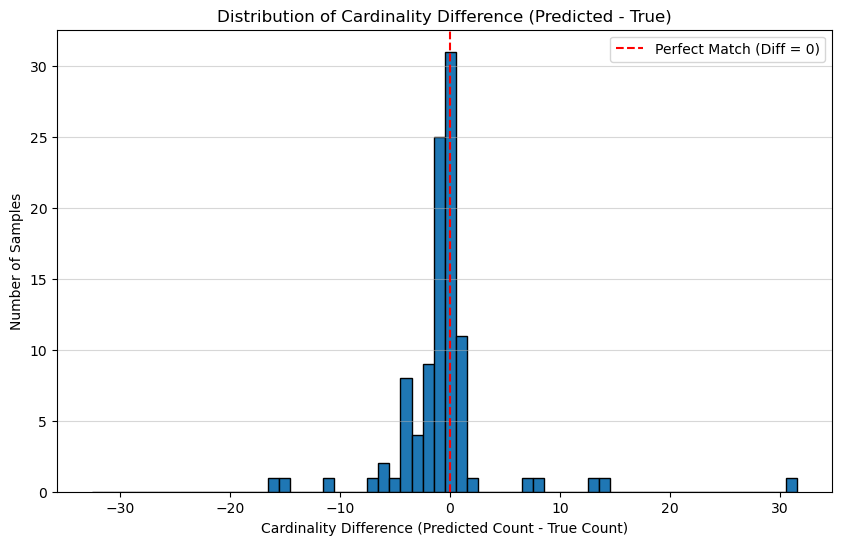

In [ ]:
cardinality_true = np.sum(y_test_transformed, axis=1)
cardinality_pred = np.sum(y_pred_test_nbcc.toarray(), axis=1)
cardinality_difference = cardinality_pred - cardinality_true

max_abs_diff = np.abs(cardinality_difference).max()
bins = np.arange(-max_abs_diff, max_abs_diff + 1, 1)

plt.figure(figsize=(10, 6))
plt.hist(
    cardinality_difference,
    bins=bins,
    edgecolor='black',
    align='left' # Align bins so the zero bar is centered
)

# Add a vertical line at zero for reference
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Perfect Match (Diff = 0)')

# Add title and labels
plt.title('Distribution of Cardinality Difference (Predicted - True)')
plt.xlabel('Cardinality Difference (Predicted Count - True Count)')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


We had a decent number of predictions that were close but many that predicted too many labels, as we suspected. We could adjust the positive threshold higher to be more in line with true cardinality.

Next we will create heatmaps for incorrect and correct predictions, by label and type.

In [ ]:
cm_array = multilabel_confusion_matrix(y_test_transformed, y_pred_test_nbcc.toarray())

df_heatmap = pd.DataFrame({
    'True Positives': cm_array[:, 1, 1],
    'False Negatives': cm_array[:, 1, 0],
    'False Positives': cm_array[:, 0, 1],
    'True Negatives': cm_array[:, 0, 0]
})

df_heatmap.index = y_test_transformed.columns.tolist()

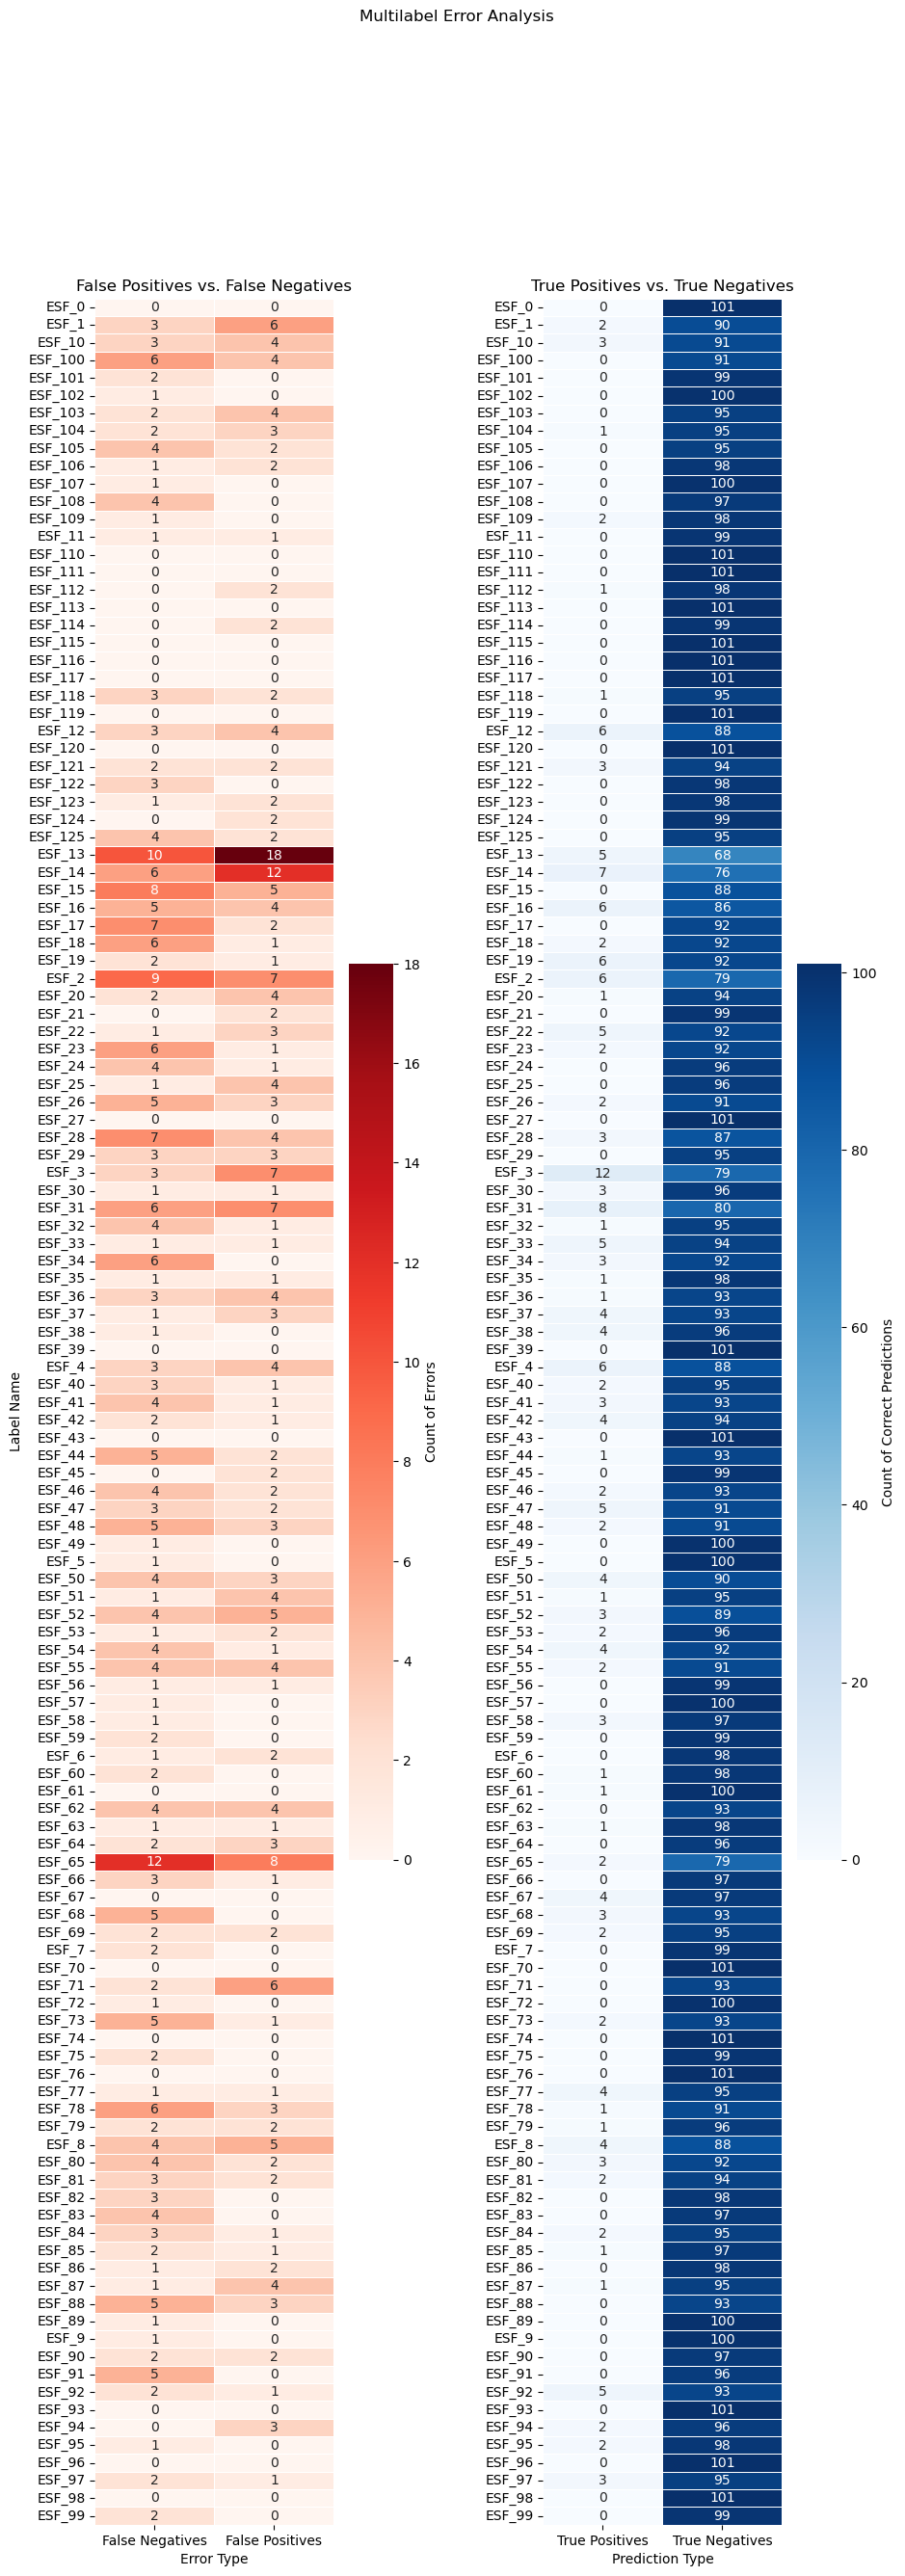

In [ ]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 30), 
)

ax_errors = axes[0]
df_errors = df_heatmap[['False Negatives', 'False Positives']]

sns.heatmap(
    df_errors,
    annot = True,
    fmt = 'd',
    cmap = 'Reds',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Errors'},
    ax = ax_errors,
)

ax_errors.set_title('False Positives vs. False Negatives')
ax_errors.set_ylabel('Label Name')
ax_errors.set_xlabel('Error Type')
current_labels = ax_errors.get_yticklabels()
ax_errors.set_yticklabels(
    current_labels,
    rotation=0,
)

ax_correct = axes[1]
df_correct = df_heatmap[['True Positives', 'True Negatives']]

sns.heatmap(
    df_correct,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Correct Predictions'},
    ax = ax_correct
)

ax_correct.set_title('True Positives vs. True Negatives')
ax_correct.set_xlabel('Prediction Type')
ax_correct.set_yticklabels(
    current_labels,
    rotation=0,
)

fig.suptitle('Multilabel Error Analysis')
plt.subplots_adjust(wspace=0.5)
plt.show()

Our model did well but does display a difference balance than we saw with our model that predicted ESFs. This time, we have a balance of false negatives and false positives rather than being skewed towards just false positives.

We will perform a label co-occurence analysis to determine label correlation differences between the test set and our predictions.

In [ ]:
# Generate a matrix of label combination counts for the test set
labels = y_test_transformed.columns.tolist()
label_len = len(labels)
true_corr = np.dot(y_test_transformed.T, y_test_transformed)
co_occurrence_df = pd.DataFrame(
    true_corr,
    index=labels,
    columns=labels,
)
co_occurrence_df

ESF_0  ESF_1  ESF_10  ESF_100  ESF_101  ESF_102  ESF_103  ESF_104  \
ESF_0        0      0       0        0        0        0        0        0   
ESF_1        0      5       1        0        0        0        1        2   
ESF_10       0      1       6        1        1        0        0        1   
ESF_100      0      0       1        6        0        0        0        0   
ESF_101      0      0       1        0        2        0        0        0   
ESF_102      0      0       0        0        0        1        0        0   
ESF_103      0      1       0        0        0        0        2        0   
ESF_104      0      2       1        0        0        0        0        3   
ESF_105      0      0       0        0        0        1        0        0   
ESF_106      0      0       0        0        0        0        0        1   
ESF_107      0      0       0        0        0        0        0        0   
ESF_108      0      0       0        0        0        1        0        0   
ESF_109      0      1       2        1        0        0        0        2   
ESF_11       0      0       0        0        0        0        0        0   
ESF_110      0      0       0        0        0        0        0        0   
ESF_111      0      0       0        0        0        0        0        0   
ESF_112      0      1       0        0        0        0        1        0   
ESF_113      0      0       0        0        0        0        0        0   
ESF_114      0      0       0        0        0        0        0        0   
ESF_115      0      0       0        0        0        0        0        0   
ESF_116      0      0       0        0        0        0        0        0   
ESF_117      0      0       0        0        0        0        0        0   
ESF_118      0      0       1        1        0        0        0        0   
ESF_119      0      0       0        0        0        0        0        0   
ESF_12       0      2       2        1        0        1        0        3   
ESF_120      0      0       0        0        0        0        0        0   
ESF_121      0      0       0        0        0        0        0        0   
ESF_122      0      1       2        1        0        0        0        2   
ESF_123      0      0       0        0        0        0        0        0   
ESF_124      0      0       0        0        0        0        0        0   
ESF_125      0      0       0        0        0        0        0        1   
ESF_13       0      2       1        0        0        0        1        3   
ESF_14       0      0       0        0        0        0        0        0   
ESF_15       0      1       1        0        2        1        0        1   
ESF_16       0      1       2        1        0        1        2        1   
ESF_17       0      2       1        0        0        0        0        3   
ESF_18       0      1       3        1        0        0        1        2   
ESF_19       0      2       3        1        0        0        2        1   
ESF_2        0      4       4        1        1        0        1        2   
ESF_20       0      0       0        0        0        0        0        1   
ESF_21       0      0       0        0        0        0        0        0   
ESF_22       0      1       0        0        0        1        1        0   
ESF_23       0      1       0        0        0        0        1        0   
ESF_24       0      0       0        0        0        1        0        0   
ESF_25       0      0       0        0        0        0        0        0   
ESF_26       0      2       2        0        2        0        0        2   
ESF_27       0      0       0        0        0        0        0        0   
ESF_28       0      1       1        0        2        1        0        2   
ESF_29       0      0       0        0        1        0        0        1   
ESF_3        0      1       3        2        1        0        0        2   
ESF_30       0      1       0  

In [ ]:
# Get a normalized version of the co-occurrence counts
label_counts = np.diag(co_occurrence_df)
normalized_co_occurrence_df = co_occurrence_df.div(
    label_counts,
    axis=0,
    )
normalized_co_occurrence_df


ESF_0     ESF_1    ESF_10   ESF_100   ESF_101   ESF_102   ESF_103  \
ESF_0      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_1      0.0  1.000000  0.200000  0.000000  0.000000  0.000000  0.200000   
ESF_10     0.0  0.166667  1.000000  0.166667  0.166667  0.000000  0.000000   
ESF_100    0.0  0.000000  0.166667  1.000000  0.000000  0.000000  0.000000   
ESF_101    0.0  0.000000  0.500000  0.000000  1.000000  0.000000  0.000000   
ESF_102    0.0  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
ESF_103    0.0  0.500000  0.000000  0.000000  0.000000  0.000000  1.000000   
ESF_104    0.0  0.666667  0.333333  0.000000  0.000000  0.000000  0.000000   
ESF_105    0.0  0.000000  0.000000  0.000000  0.000000  0.250000  0.000000   
ESF_106    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_107    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_108    0.0  0.000000  0.000000  0.000000  0.000000  0.250000  0.000000   
ESF_109    0.0  0.333333  0.666667  0.333333  0.000000  0.000000  0.000000   
ESF_11     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_110    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_111    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_112    0.0  1.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
ESF_113    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_114    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_115    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_116    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_117    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_118    0.0  0.000000  0.250000  0.250000  0.000000  0.000000  0.000000   
ESF_119    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_12     0.0  0.222222  0.222222  0.111111  0.000000  0.111111  0.000000   
ESF_120    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_121    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_122    0.0  0.333333  0.666667  0.333333  0.000000  0.000000  0.000000   
ESF_123    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_124    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_125    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_13     0.0  0.133333  0.066667  0.000000  0.000000  0.000000  0.066667   
ESF_14     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_15     0.0  0.125000  0.125000  0.000000  0.250000  0.125000  0.000000   
ESF_16     0.0  0.090909  0.181818  0.090909  0.000000  0.090909  0.181818   
ESF_17     0.0  0.285714  0.142857  0.000000  0.000000  0.000000  0.000000   
ESF_18     0.0  0.125000  0.375000  0.125000  0.000000  0.000000  0.125000   
ESF_19     0.0  0.250000  0.375000  0.125000  0.000000  0.000000  0.250000   
ESF_2      0.0  0.266667  0.266667  0.066667  0.066667  0.000000  0.066667   
ESF_20     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_21     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_22     0.0  0.166667  0.000000  0.000000  0.000000  0.166667  0.166667   
ESF_23     0.0  0.125000  0.000000  0.000000  0.000000  0.000000  0.125000   
ESF_24     0.0  0.000000  0.000000  0.000000  0.000000  0.250000  0.000000   
ESF_25     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ESF_26     0.0  0.285714  0.285714  0.000000  0.285714  0.000000  0.000000   
ESF_27     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ESF_28     0.0  0.100000  0.100000  0.000000  0.200000  0.100000  0.000000   
ESF_29     0.0  0.000000  0.000000  0.000000  0.333333  0.000000  0.000000   
ESF_3      0.0  0.066667  0.200000  0.133333  0.066667  0.000000  0.000000   
ESF_30     0.0  0.250000  0.000

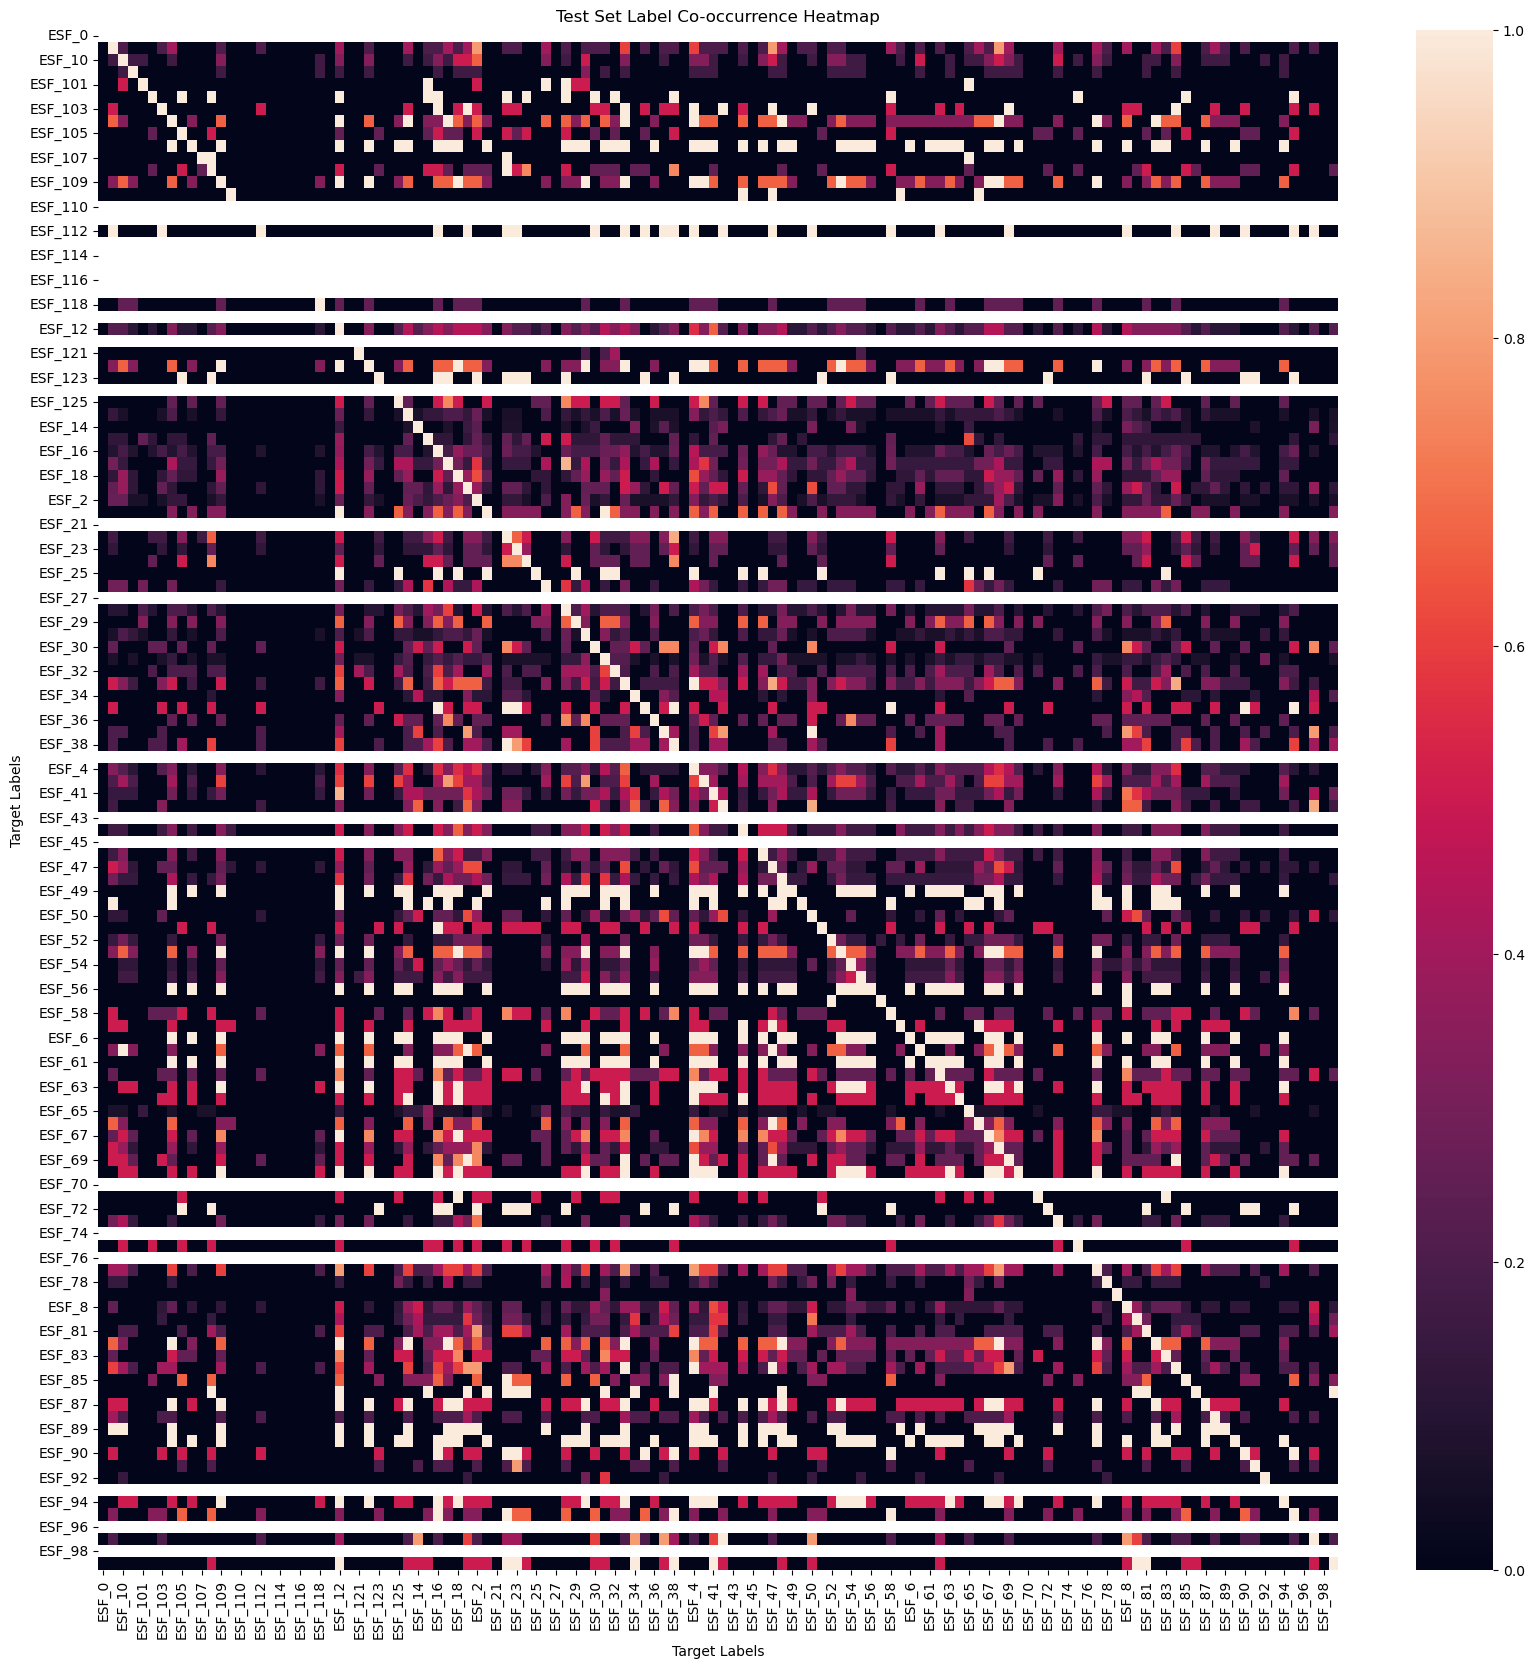

In [123]:
plt.figure(figsize=(20,20))
sns.heatmap(
    normalized_co_occurrence_df,
    annot=False,
    )
plt.title('Test Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

In [124]:
# Generate a matrix of label combination counts for the prediction set
pred_corr = np.dot(y_pred_test_ovr.T, y_pred_test_ovr)
pred_co_occurrence_df = pd.DataFrame(
    pred_corr,
    index=labels,
    columns=labels,
)

pred_co_occurrence_df


ESF_0  ESF_1  ESF_10  ESF_100  ESF_101  ESF_102  ESF_103  ESF_104  \
ESF_0        0      0       0        0        0        0        0        0   
ESF_1        0      9       4        1        0        0        1        3   
ESF_10       0      4       8        1        0        0        2        4   
ESF_100      0      1       1        4        0        0        0        0   
ESF_101      0      0       0        0        0        0        0        0   
ESF_102      0      0       0        0        0        0        0        0   
ESF_103      0      1       2        0        0        0        4        2   
ESF_104      0      3       4        0        0        0        2        4   
ESF_105      0      1       0        0        0        0        0        0   
ESF_106      0      2       2        0        0        0        1        2   
ESF_107      0      0       0        0        0        0        0        0   
ESF_108      0      0       0        0        0        0        0        0   
ESF_109      0      2       2        0        0        0        1        2   
ESF_11       0      0       0        0        0        0        0        0   
ESF_110      0      0       0        0        0        0        0        0   
ESF_111      0      0       0        0        0        0        0        0   
ESF_112      0      3       2        0        0        0        1        1   
ESF_113      0      0       0        0        0        0        0        0   
ESF_114      0      0       0        0        0        0        0        0   
ESF_115      0      0       0        0        0        0        0        0   
ESF_116      0      0       0        0        0        0        0        0   
ESF_117      0      1       0        0        0        0        0        0   
ESF_118      0      1       1        0        0        0        1        1   
ESF_119      0      0       0        0        0        0        0        0   
ESF_12       0      3       4        0        0        0        3        4   
ESF_120      0      0       0        0        0        0        0        0   
ESF_121      0      0       0        0        0        0        0        0   
ESF_122      0      0       0        0        0        0        0        0   
ESF_123      0      0       1        0        0        0        0        0   
ESF_124      0      2       2        0        0        0        1        2   
ESF_125      0      2       2        0        0        0        1        2   
ESF_13       0      4       2        1        0        0        0        1   
ESF_14       0      1       2        1        0        0        3        1   
ESF_15       0      4       3        0        0        0        1        2   
ESF_16       0      5       4        0        0        0        2        3   
ESF_17       0      4       3        0        0        0        1        2   
ESF_18       0      4       4        1        0        0        2        4   
ESF_19       0      4       4        0        0        0        3        4   
ESF_2        0      8       4        1        0        0        2        3   
ESF_20       0      3       3        0        0        0        2        3   
ESF_21       0      1       1        0        0        0        1        1   
ESF_22       0      5       4        0        0        0        1        2   
ESF_23       0      2       2        0        0        0        0        0   
ESF_24       0      0       1        0        0        0        0        0   
ESF_25       0      4       3        0        0        0        1        2   
ESF_26       0      2       2        2        0        0        2        2   
ESF_27       0      0       0        0        0        0        0        0   
ESF_28       0      5       3        1        0        0        2        3   
ESF_29       0      0       0        0        0        0        0        0   
ESF_3        0      5       5        2        0        0        2        4   
ESF_30       0      0       2  

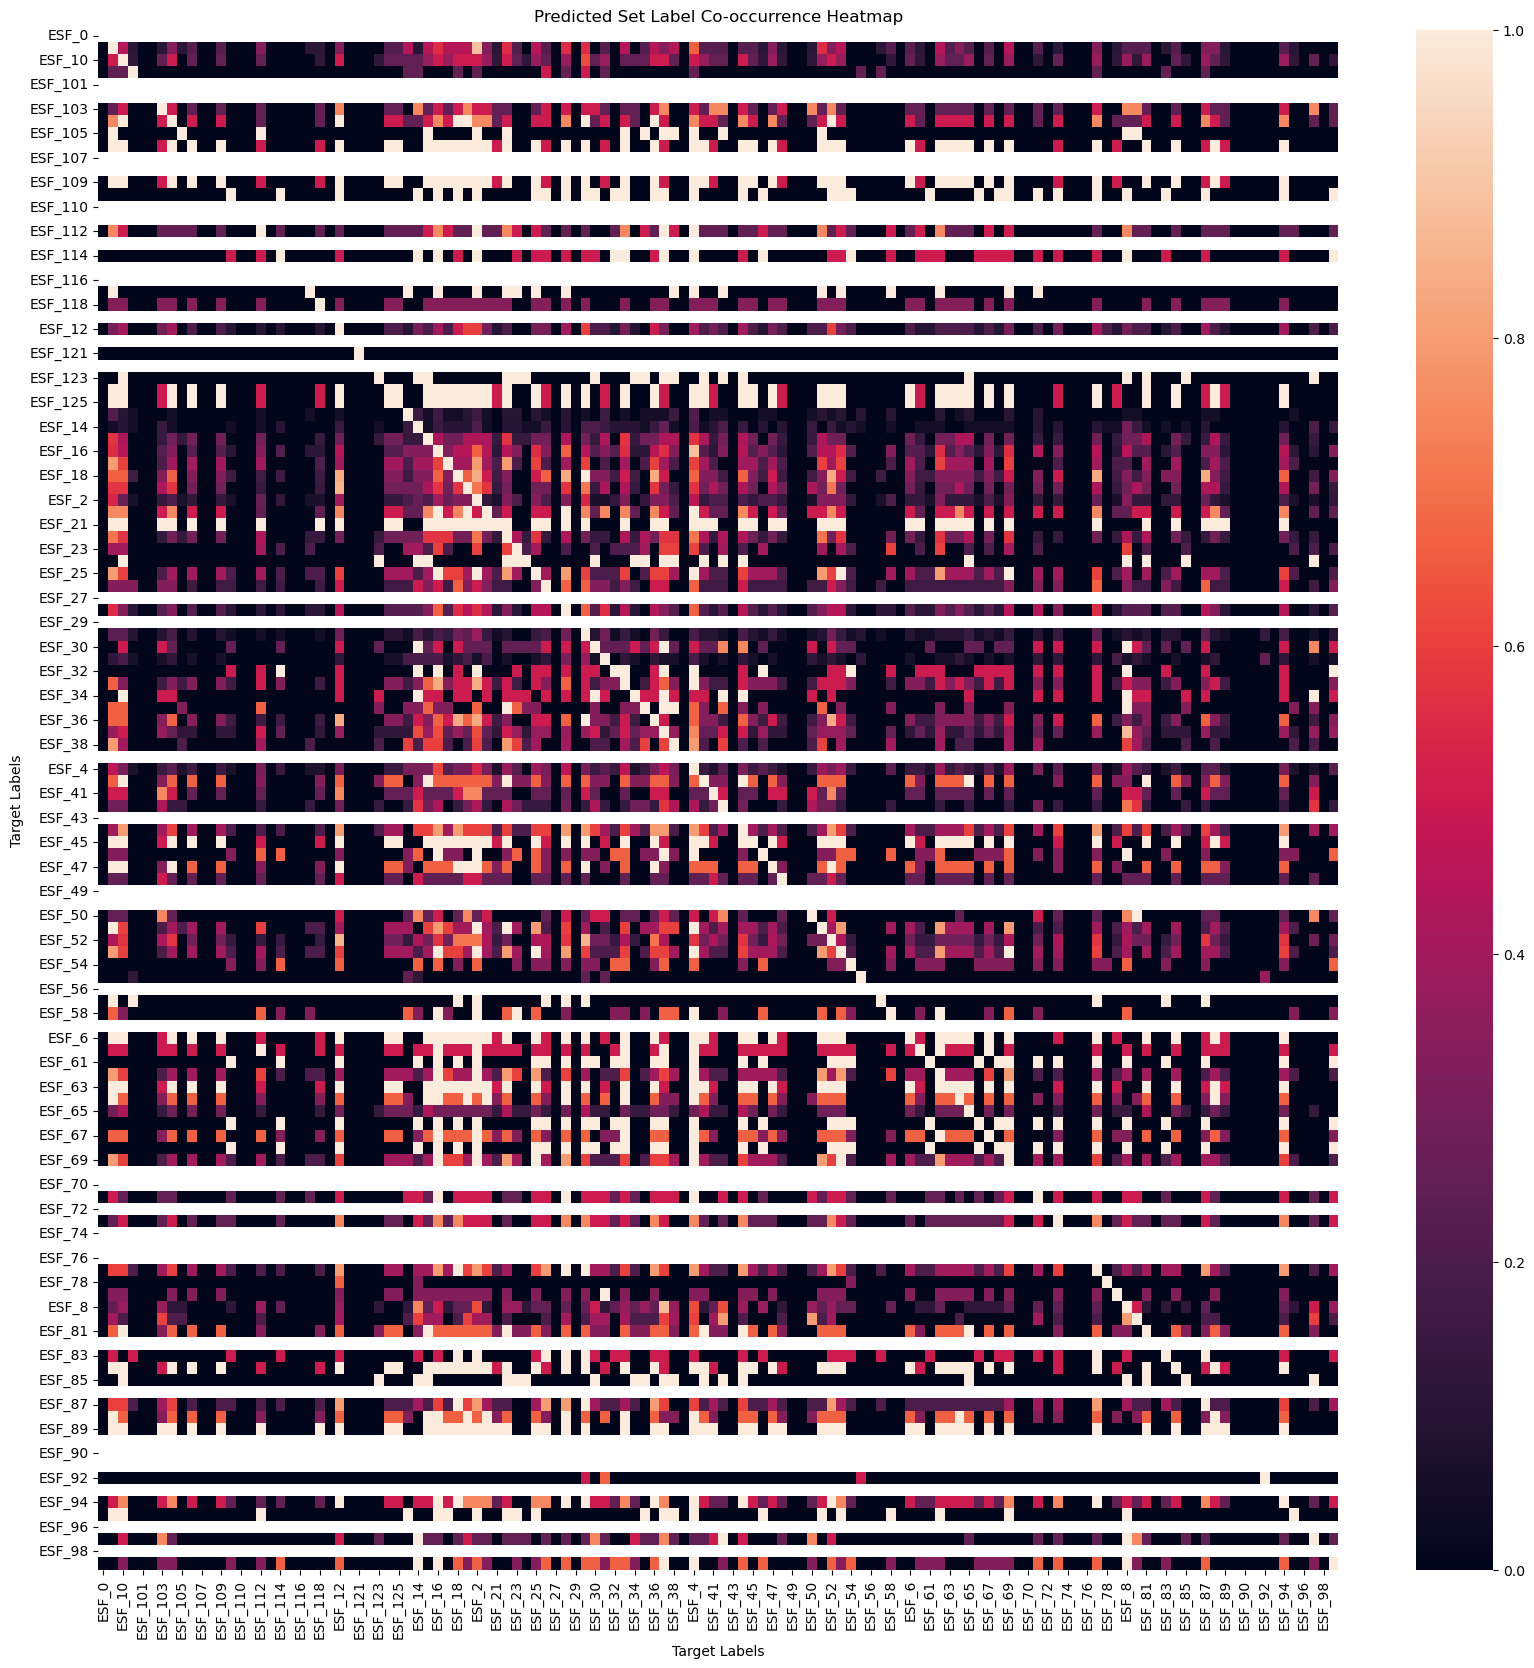

In [125]:
pred_label_counts = np.diag(pred_co_occurrence_df)
normalized_pred_co_occurrence_df = pred_co_occurrence_df.div(
    pred_label_counts,
    axis=0,
    )
plt.figure(figsize=(20,20))
sns.heatmap(
    normalized_pred_co_occurrence_df,
    annot=False,
    )
plt.title('Predicted Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

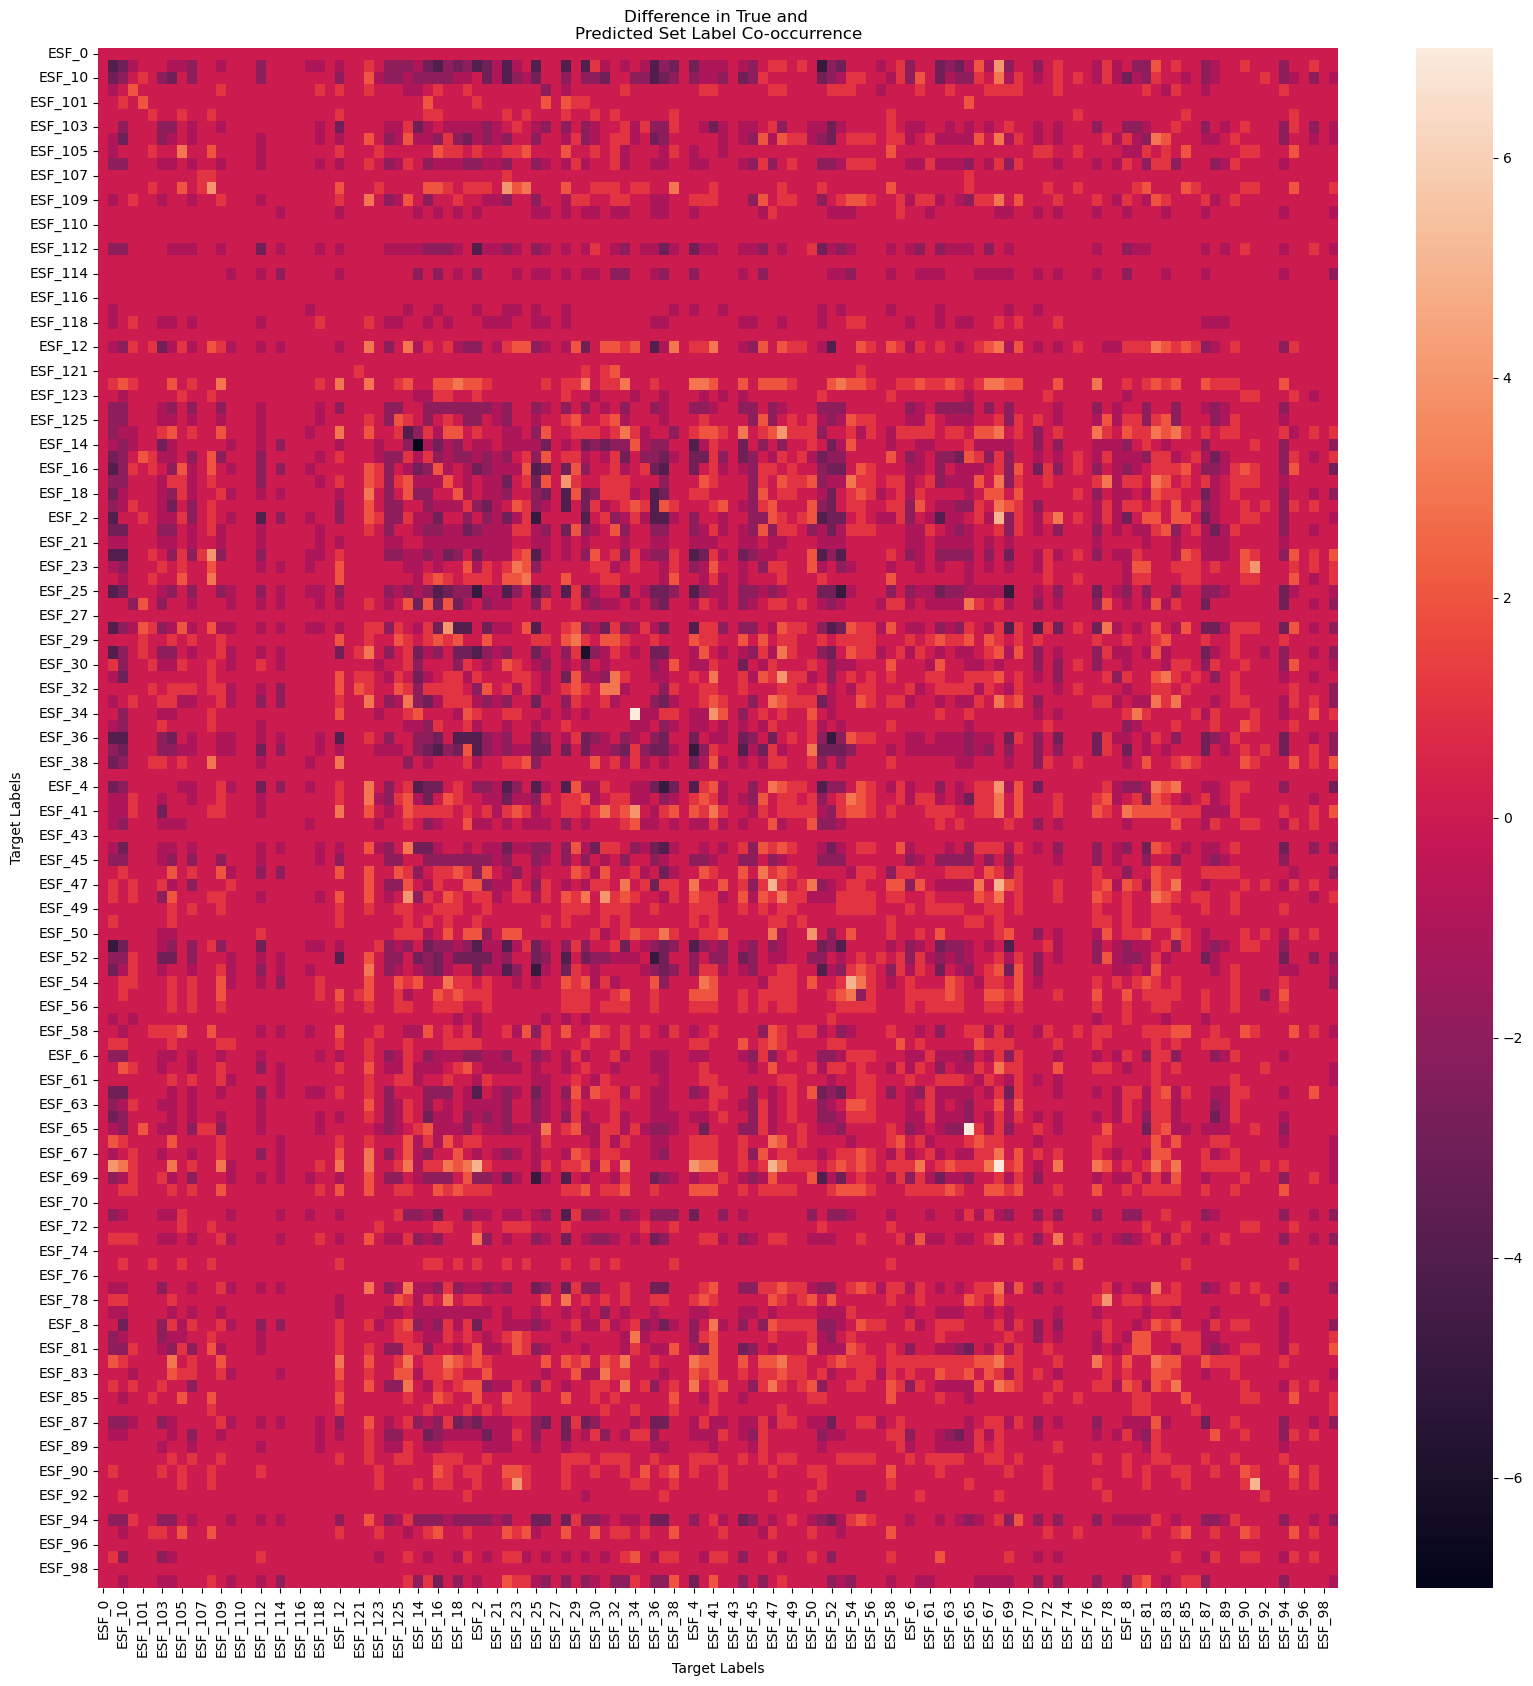

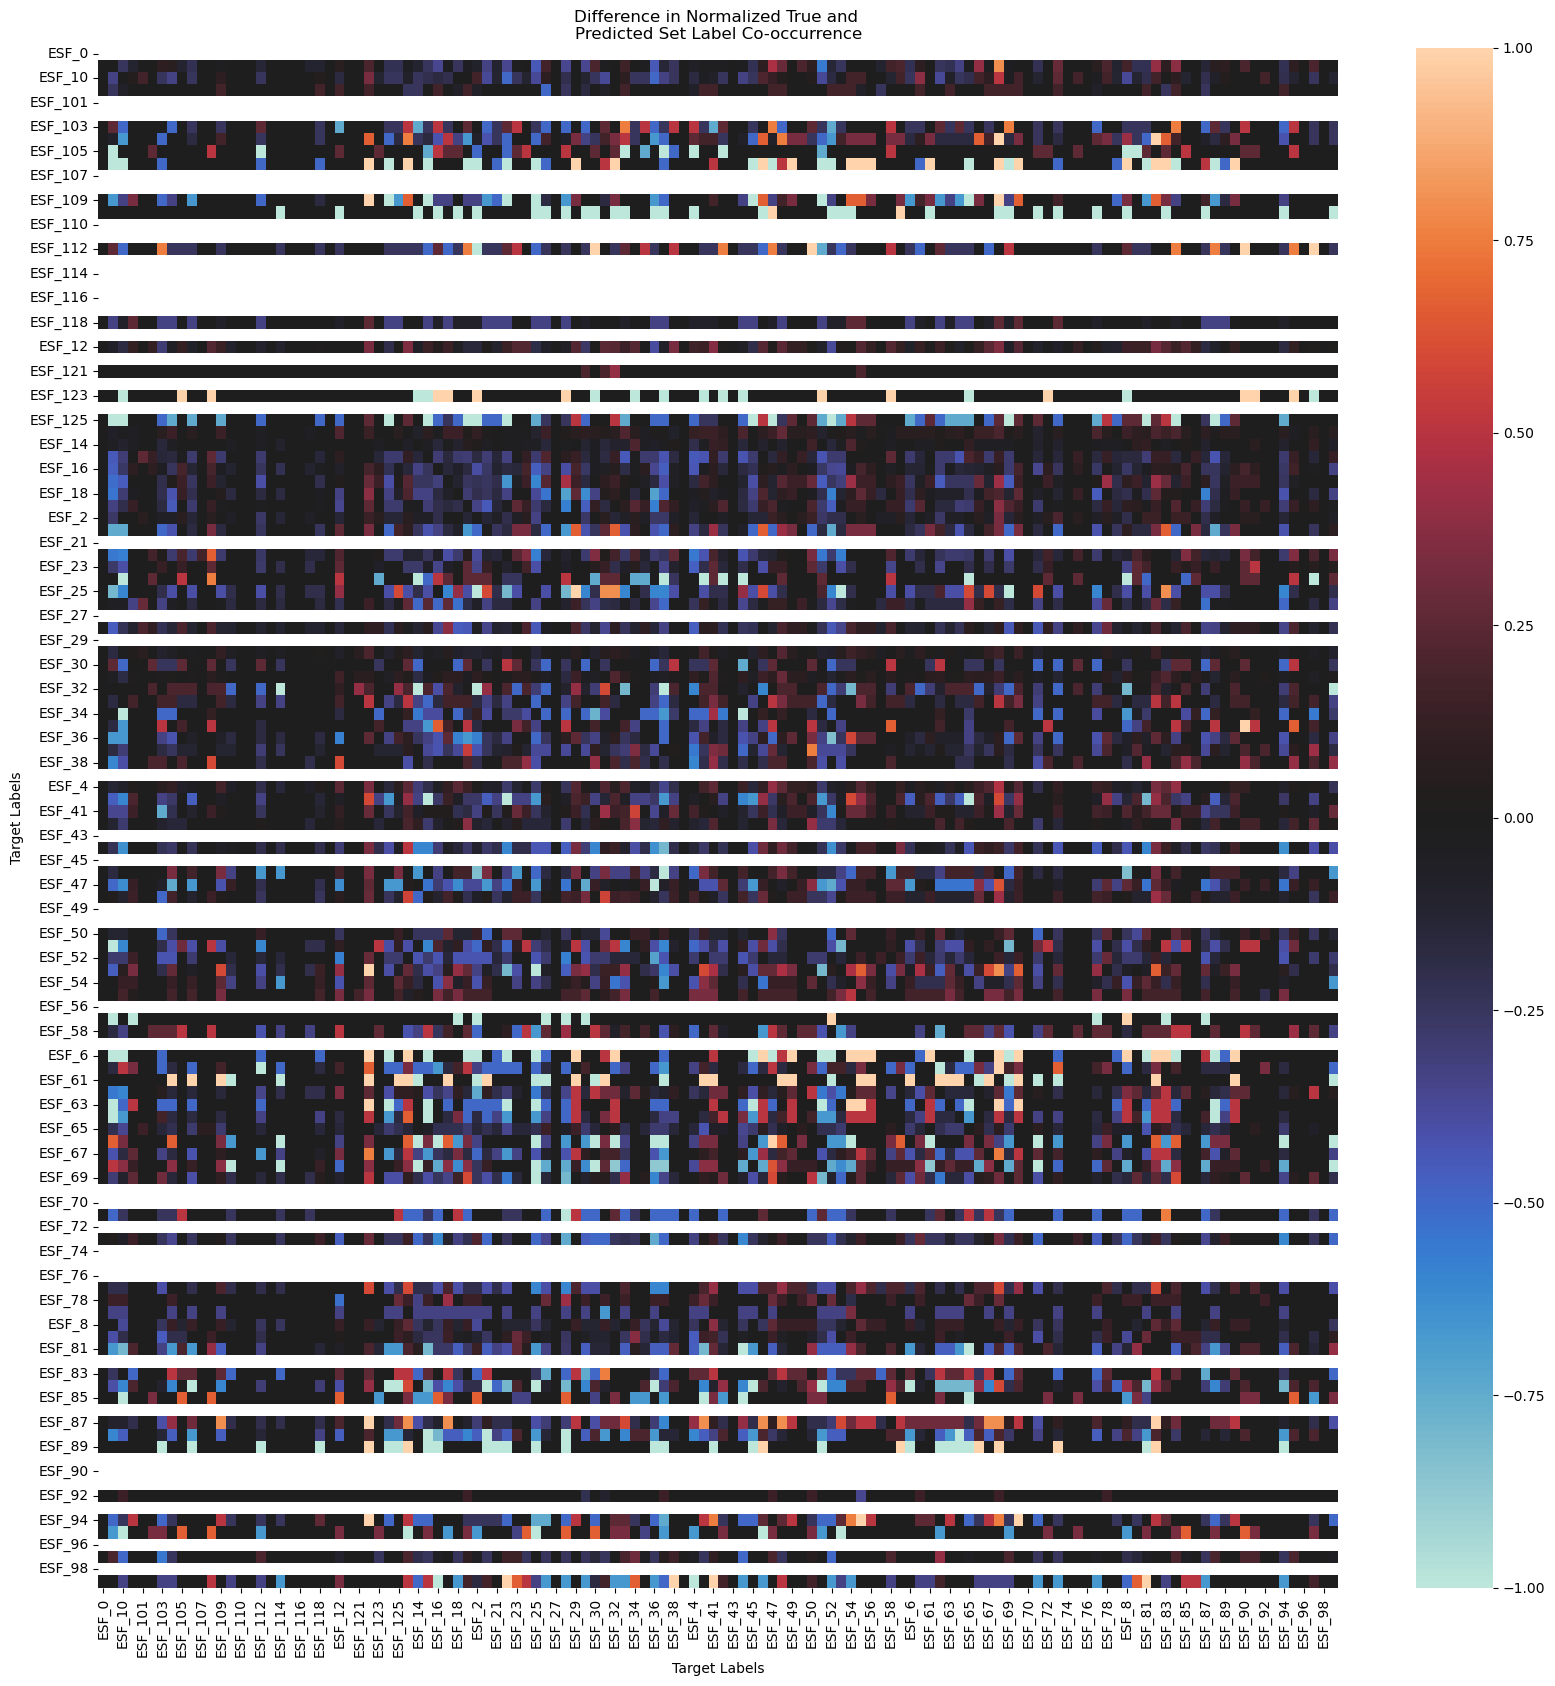

In [126]:
# Compare the differences between the test set and the prediction set

difference_df = co_occurrence_df - pred_co_occurrence_df

plt.figure(figsize=(20,20))
sns.heatmap(
    difference_df,
)
plt.title('Difference in True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

norm_difference_df = normalized_co_occurrence_df - normalized_pred_co_occurrence_df

plt.figure(figsize=(20,20))
sns.heatmap(
    norm_difference_df,
    center=0
)
plt.title('Difference in Normalized True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

There are definitely combinations of target labels that were underpredicted, with the worst being ESFs 9 and 14. There were other combinations with ESF 14 that also did poorly, both with underpredictions and overpredictions. It appears that ESF 15 and ESF 0 was not a real combination in the test set but is one that was predicted. Overall, our worst performance was on rare events, such as when ESFs 14 and 15 are present, and some of the more frequently occurring ESFs such as 0 and 13, though we did reasonably well when ESFs 3 or 7 were present.

We will now create a dataframe consisting of the label combinations and the error between the test set and the prediction set. Negative values will be overpredictions and positive values will be underpredictions.

In [127]:
difference_stack = (difference_df.stack().reset_index(name='difference').query('level_0 != level_1'))
largest_errors = difference_stack.reindex(difference_stack['difference'].abs().sort_values(ascending=False).index)
largest_errors.head(15)

level_0 level_1  difference
9380   ESF_52  ESF_36          -5
5636   ESF_25  ESF_69          -5
9494   ESF_53  ESF_25          -5
5582   ESF_25   ESF_2          -5
11504  ESF_68   ESF_2           5
11636  ESF_69  ESF_25          -5
11534  ESF_68  ESF_47           5
5619   ESF_25  ESF_53          -5
9199   ESF_51   ESF_1          -5
8659   ESF_47  ESF_68           5
199     ESF_1  ESF_51          -5
7617    ESF_4  ESF_37          -5
4832    ESF_2  ESF_25          -5
7242   ESF_37   ESF_4          -5
7130   ESF_36  ESF_52          -5

In [128]:
largest_errors.tail(30)

level_0  level_1  difference
5904   ESF_27   ESF_83           0
5905   ESF_27   ESF_84           0
5906   ESF_27   ESF_85           0
5907   ESF_27   ESF_86           0
5908   ESF_27   ESF_87           0
5909   ESF_27   ESF_88           0
15853  ESF_99   ESF_79           0
15857  ESF_99   ESF_82           0
15859  ESF_99   ESF_84           0
15863  ESF_99   ESF_88           0
15864  ESF_99   ESF_89           0
15865  ESF_99    ESF_9           0
15866  ESF_99   ESF_90           0
15867  ESF_99   ESF_91           0
15838  ESF_99   ESF_65           0
15843  ESF_99    ESF_7           0
15844  ESF_99   ESF_70           0
15846  ESF_99   ESF_72           0
15848  ESF_99   ESF_74           0
15849  ESF_99   ESF_75           0
15850  ESF_99   ESF_76           0
15852  ESF_99   ESF_78           0
26      ESF_0  ESF_121           0
27      ESF_0  ESF_122           0
28      ESF_0  ESF_123           0
29      ESF_0  ESF_124           0
30      ESF_0  ESF_125           0
31      ESF_0   ESF_13           0
32      ESF_0   ESF_14           0
33      ESF_0   ESF_15           0

Many of our best and worst performances were on rare events, such as when ESFs 14 and/or 15 are present. We did manage to get all seven instances of ESFs 9 and 2 correct.

Let's compare it to the differences in the normalized sets.

In [129]:
normalized_difference_stack = (normalized_co_occurrence_df.stack().reset_index(name='difference').query('level_0 != level_1'))
normalized_largest_errors = normalized_difference_stack.reindex(normalized_difference_stack['difference'].abs().sort_values(ascending=False).index)
normalized_largest_errors.head(15)

level_0 level_1  difference
8980    ESF_64  ESF_16         1.0
8977    ESF_64  ESF_13         1.0
8999    ESF_64  ESF_33         1.0
13084   ESF_99  ESF_81         1.0
6886    ESF_49   ESF_6         1.0
6871    ESF_49  ESF_46         1.0
6908    ESF_49   ESF_8         1.0
6911    ESF_49  ESF_82         1.0
6873    ESF_49  ESF_48         1.0
6879    ESF_49  ESF_53         1.0
6897    ESF_49   ESF_7         1.0
6888    ESF_49  ESF_61         1.0
1044   ESF_106  ESF_18         1.0
6961     ESF_5  ESF_13         1.0
6963     ESF_5  ESF_15         1.0

In [130]:
normalized_largest_errors.tail(15)

level_0  level_1  difference
13014  ESF_99   ESF_18         0.0
13018  ESF_99   ESF_21         0.0
13022  ESF_99   ESF_25         0.0
13023  ESF_99   ESF_26         0.0
13024  ESF_99   ESF_27         0.0
13025  ESF_99   ESF_28         0.0
13026  ESF_99   ESF_29         0.0
13001  ESF_99  ESF_119         0.0
13003  ESF_99  ESF_120         0.0
13004  ESF_99  ESF_121         0.0
13005  ESF_99  ESF_122         0.0
13006  ESF_99  ESF_123         0.0
13007  ESF_99  ESF_124         0.0
13008  ESF_99  ESF_125         0.0
13075  ESF_99   ESF_73         0.0

In [131]:

groups = {
    'state': state_columns,
    'region': region_columns,
    'declarationType': declaration_columns,
    'designatedIncidentTypes': type_columns
}

def grouped_feature_permutation(
    model,
    X,
    y,
    groups,
    metric_,
):
    baseline = combined_score(y_true=y, y_pred=model.predict(X = X))
    group_importance = {}
    group_importance['baseline'] = baseline
    for group, columns in groups.items():
        score_changes = []
        rng = np.random.default_rng(seed = random_state)
        for i in range(1,11):
            X_perm = X.copy()
            shuffled_ind = rng.permutation(X.index)
            X_perm[columns] = X_perm[columns].values[shuffled_ind]
            perm_score = combined_score(y_true= y, y_pred=model.predict(X_perm),)
            score_changes.append(perm_score)
        group_importance[group] = (f'Mean: {np.mean(score_changes)}', #Mean
                                   f'Max: {np.max(score_changes)}', #Max
                                   f'Min: {np.min(score_changes)}', #Min
                                   f'Std: {np.std(score_changes)}') #Std
    labels = []
    means = []
    errors = []

    for key, value in group_importance.items():
        if key == "baseline":
            y_line = (value)
        else:
            mean_val = float(value[0].split(":")[1])
            std_val = float(value[3].split(":")[1])
            labels.append(key)
            means.append(mean_val)
            errors.append(std_val)
    # Create a plot of values
    plt.figure(figsize=(10,6))
    plt.bar(labels,
            means,
            yerr=errors)
    plt.axhline(y=y_line,
                color='k',
                linestyle='--',
                label='Baseline',
                )
    plt.ylim([0, 1.5])
    plt.ylabel('Combined Metric Score')
    plt.title('Performance Given Permuted Values of Feature Groups')
    plt.tight_layout()
    plt.show()

    return group_importance

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/jos

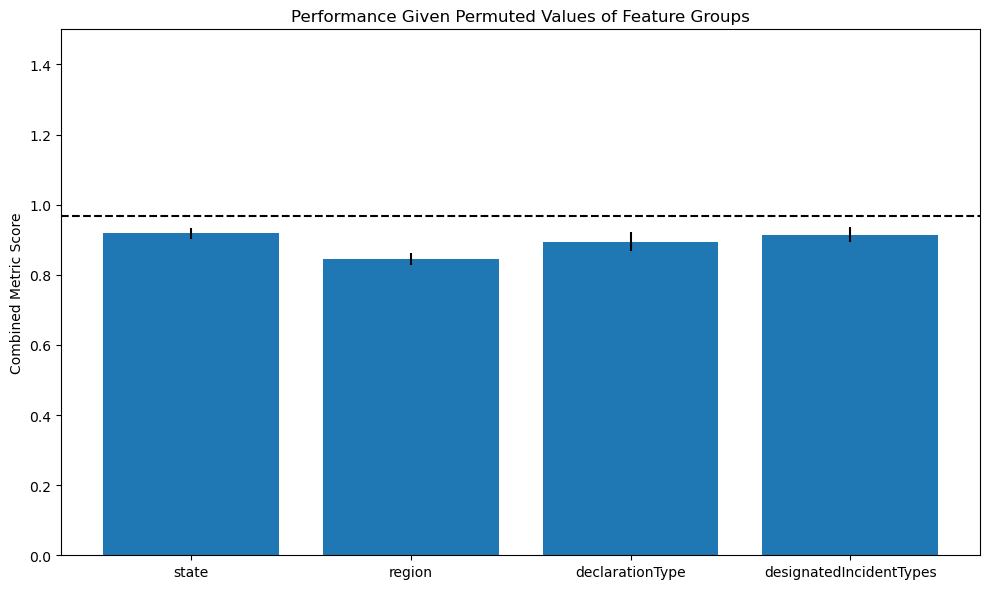

{'baseline': 0.966507569938421,
 'state': ('Mean: 0.918398226091161',
  'Max: 0.9423374888553632',
  'Min: 0.8985612957326969',
  'Std: 0.015074476757158227'),
 'region': ('Mean: 0.8456922316352099',
  'Max: 0.8803609268478882',
  'Min: 0.8215611105228735',
  'Std: 0.017691362972344263'),
 'declarationType': ('Mean: 0.8945445649780541',
  'Max: 0.9385047799908022',
  'Min: 0.8580950599614875',
  'Std: 0.0263484098582741'),
 'designatedIncidentTypes': ('Mean: 0.9143961097085039',
  'Max: 0.9517501818123104',
  'Min: 0.8694907802472711',
  'Std: 0.021968002114013497')}

In [132]:
perm_scores = grouped_feature_permutation(study_ovrxgb_tuned,
                                          X_test_transformed,
                                          y_test_transformed,
                                          groups,
                                          F1_Macro_Avg)

perm_scores

Permutations of state actually seem to have improved the results over the baseline, whereas every other group results in lower scores. Changing the designatedIncidentTypes has the biggest negative impact on the final metric score compared to the baseline.

Let us start analyzing edge cases. We can begin by picking a few rows from the same incident and comparing outcomes for different states.

In [133]:
X_test['incidentId'].value_counts()

incidentId
2012102505    13
2021082601     8
2020091301     6
2021081902     3
2023081703     3
2018031201     2
2020041101     2
2021081801     2
2020010701     2
2022122101     2
2023030901     2
2024042701     2
2024052402     2
2024080901     2
2013051001     1
2013050601     1
2016092301     1
2016100501     1
2017012001     1
2016100502     1
2013062801     1
2013070101     1
2013070102     1
2013060301     1
2014061802     1
2014071703     1
2015021101     1
2015050801     1
2016012701     1
2016061101     1
2016081301     1
2014020501     1
2019110801     1
2019110101     1
2019101801     1
2018082801     1
2018041602     1
2018022302     1
2017110602     1
2017110601     1
2017021001     1
2017072901     1
2017052601     1
2017031101     1
2021080901     1
2021062401     1
2020082004     1
2020020701     1
2022081903     1
2022070501     1
2022062801     1
2022051202     1
2022010701     1
2022010301     1
2023081101     1
2023030102     1
2023090401     1
2023082901     1
202

In [134]:
X_test['incidentId'].value_counts()

incidentId
2012102505    13
2021082601     8
2020091301     6
2021081902     3
2023081703     3
2018031201     2
2020041101     2
2021081801     2
2020010701     2
2022122101     2
2023030901     2
2024042701     2
2024052402     2
2024080901     2
2013051001     1
2013050601     1
2016092301     1
2016100501     1
2017012001     1
2016100502     1
2013062801     1
2013070101     1
2013070102     1
2013060301     1
2014061802     1
2014071703     1
2015021101     1
2015050801     1
2016012701     1
2016061101     1
2016081301     1
2014020501     1
2019110801     1
2019110101     1
2019101801     1
2018082801     1
2018041602     1
2018022302     1
2017110602     1
2017110601     1
2017021001     1
2017072901     1
2017052601     1
2017031101     1
2021080901     1
2021062401     1
2020082004     1
2020020701     1
2022081903     1
2022070501     1
2022062801     1
2022051202     1
2022010701     1
2022010301     1
2023081101     1
2023030102     1
2023090401     1
2023082901     1
202

In [137]:
print(X_test.iloc[8], y_test_transformed.iloc[8], y_pred_test_nbcc.toarray()[8])

incidentId                      2012102505
state                                   PA
designatedIncidentTypes        [Hurricane]
declarationType                         EM
region                                   3
ESF                        [8.0, 3.0, 4.0]
year                                2012.0
Name: 8, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     0
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     0
ESF_15     0
ESF_16     0
ESF_17     0
ESF_18     0
ESF_19     0
ESF_2      1
ESF_20     0
ESF_21     0
ESF_22     0
ESF_23     0
ESF_24     0
ESF_25     0
ESF_26     0
ESF_27     0
ESF_28     0
ESF_29     0
ESF_3      0
ESF_30     0
ESF_31     0


Next we can pick out some of our worse predictions and best predictions and look for patterns from those.

In [138]:
print(X_test.iloc[1], y_test_transformed.iloc[1], y_pred_test_nbcc.toarray()[1])


incidentId                  2012102505
state                               DC
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
ESF                              [4.0]
year                            2012.0
Name: 1, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     0
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     0
ESF_15     0
ESF_16     0
ESF_17     0
ESF_18     0
ESF_19     0
ESF_2      0
ESF_20     0
ESF_21     0
ESF_22     0
ESF_23     0
ESF_24     0
ESF_25     0
ESF_26     0
ESF_27     0
ESF_28     0
ESF_29     0
ESF_3      0
ESF_30     0
ESF_31     0
ESF_32     0
ESF_33     0
ES

In [141]:
print(X_test.iloc[0], y_test_transformed.iloc[0], y_pred_test_nbcc.toarray()[0])


incidentId                                                        2012102505
state                                                                     CT
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     1
ESF                        [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
year                                                                  2012.0
Name: 0, dtype: object ESF_0      0
ESF_1      0
ESF_10     1
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     0
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     0
ESF_15   

Here we see five match incidentId values with matching designatedIncidentTypes across five different states with varying declarationTypes. This helps show some of the difficulties in predicting ESFs based on very few features. The disaster in Connecticut varies from the disaster in Virginia only by state, but the incident in Connecticut required nine different ESFs while in Virginia is only required one. It is interesting that the event in Connecticut did not result in nearly as many positive predicted labels as the incident in Virgina. Had those been flipped, our outcomes would have improved in both locations.

Lets look at some of the incidents in the test set with large label sets to see how we performed in those cases.

In [142]:
label_set_counts_true = y_test_transformed.sum(axis=1)
edge_cases_large_label_sets = label_set_counts_true.sort_values()
edge_cases_large_label_sets[-10:]

50    17
45    17
65    18
82    20
89    20
46    25
26    26
7     31
6     35
64    44
dtype: int64

In [143]:
print(X_test.iloc[64], y_test_transformed.iloc[64], y_pred_test_nbcc.toarray()[64])


incidentId                                                        2021082601
state                                                                     LA
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     6
ESF                        [0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2021.0
Name: 64, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    1
ESF_105    0
ESF_106    1
ESF_107    0
ESF_108    0
ESF_109    1
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     1
ESF_120    0
ESF_121    0
ESF_122    1
ESF_123    0
ESF_124    0
ESF_125    1
ESF_13     1
ESF_14     0
ESF_15  

In [144]:
print(X_test.iloc[6], y_test_transformed.iloc[6], y_pred_test_nbcc.toarray()[6])


incidentId                                                        2012102505
state                                                                     NJ
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     2
ESF                        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2012.0
Name: 6, dtype: object ESF_0      0
ESF_1      1
ESF_10     1
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    1
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    1
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     1
ESF_120    0
ESF_121    0
ESF_122    1
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     1
ESF_14     0
ESF_15   

In [145]:
print(X_test.iloc[7], y_test_transformed.iloc[7], y_pred_test_nbcc.toarray()[7])


incidentId                                                        2012102505
state                                                                     NY
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           DR
region                                                                     2
ESF                        [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2012.0
Name: 7, dtype: object ESF_0      0
ESF_1      0
ESF_10     1
ESF_100    1
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    1
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    1
ESF_119    0
ESF_12     1
ESF_120    0
ESF_121    0
ESF_122    1
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     0
ESF_15   

We did fairly well on the large datasets. Let's look for instances with the worst differences in cardinality.

In [147]:
label_set_counts_pred = y_pred_test_nbcc.toarray().sum(axis=1)
label_set_counts_true-label_set_counts_pred


0      -8.0
1       1.0
2       0.0
3       1.0
4       0.0
5       1.0
6      -7.0
7     -32.0
8       4.0
9       1.0
10     -1.0
11      0.0
12      4.0
13      0.0
14     -1.0
15      0.0
16      0.0
17      0.0
18      0.0
19      4.0
20      0.0
21      3.0
22      0.0
23      1.0
24      2.0
25      0.0
26     15.0
27      0.0
28      0.0
29      0.0
30     -1.0
31     -1.0
32      0.0
33     -1.0
34      0.0
35      1.0
36      3.0
37     -1.0
38     -1.0
39      1.0
40      1.0
41      0.0
42      1.0
43      0.0
44      0.0
45      4.0
46      7.0
47      0.0
48      1.0
49      1.0
50    -14.0
51      4.0
52      2.0
53      6.0
54      3.0
55      4.0
56      1.0
57      4.0
58      0.0
59     -2.0
60      1.0
61      2.0
62      0.0
63    -13.0
64     16.0
65     11.0
66      1.0
67      6.0
68      3.0
69      5.0
70      1.0
71     -1.0
72      0.0
73     -1.0
74      1.0
75      1.0
76      0.0
77      0.0
78      1.0
79      1.0
80     -1.0
81      4.0
82      1.0
83  

In [148]:
print(X_test.iloc[26], y_test_transformed.iloc[26], y_pred_test_nbcc.toarray()[26])


incidentId                                                        2016081301
state                                                                     LA
designatedIncidentTypes                                              [Flood]
declarationType                                                           DR
region                                                                     6
ESF                        [1.0, 3.0, 5.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12....
year                                                                  2016.0
Name: 26, dtype: object ESF_0      0
ESF_1      1
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    1
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     1
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     1
ESF_14     0
ESF_15  

In [149]:
print(X_test.iloc[50], y_test_transformed.iloc[50], y_pred_test_nbcc.toarray()[50])


incidentId                                                        2020082004
state                                                                     CA
designatedIncidentTypes                                               [Fire]
declarationType                                                           DR
region                                                                     9
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
year                                                                  2020.0
Name: 50, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    1
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     1
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     0
ESF_15  

In [150]:
print(X_test.iloc[65], y_test_transformed.iloc[65], y_pred_test_nbcc.toarray()[65])


incidentId                                                        2021082601
state                                                                     LA
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           EM
region                                                                     6
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, ...
year                                                                  2021.0
Name: 65, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     1
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    1
ESF_13     0
ESF_14     0
ESF_15  

Here we see a hurricane and a fire that generated very few ESFs in reality but our model predicts the need for many more.

We will round out our error analysis by checking predictions with the worst Jaccard similarity scores.

In [152]:
# Find predictions with the lowest Jaccard similarity between the test set and the prediction set.

jaccard_series = pd.Series(
    [
        jaccard_score(y_test_transformed.iloc[i], y_pred_test_nbcc.toarray()[i], average='macro')
        for i in range(len(y_test_transformed))
    ],
    index=y_test_transformed.index
)
jaccard_series.sort_values()


63     0.439423
50     0.442509
91     0.452381
54     0.472222
69     0.472222
74     0.472222
57     0.476190
55     0.476190
81     0.476190
90     0.476190
71     0.480159
66     0.480159
48     0.480159
21     0.480159
19     0.484127
8      0.484127
88     0.484127
61     0.484127
92     0.484127
94     0.484127
68     0.488095
70     0.488095
36     0.488095
10     0.488095
23     0.488095
49     0.488095
52     0.492063
62     0.492063
16     0.492063
22     0.492063
2      0.492063
13     0.492063
77     0.492063
72     0.492063
85     0.492063
76     0.492063
47     0.492063
44     0.492063
32     0.492063
4      0.492063
15     0.492063
11     0.492063
18     0.492063
20     0.492063
87     0.492063
86     0.492063
84     0.492063
26     0.492608
56     0.496032
40     0.496032
35     0.496032
75     0.496032
83     0.496032
1      0.496032
5      0.496032
3      0.496032
96     0.496032
78     0.496032
79     0.496032
7      0.499472
6      0.500910
89     0.504333
0      0

In [153]:
print(X_test.iloc[63], y_test_transformed.iloc[63], y_pred_test_nbcc.toarray()[63])


incidentId                                                        2021081902
state                                                                     RI
designatedIncidentTypes                                          [Hurricane]
declarationType                                                           EM
region                                                                     1
ESF                        [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, ...
year                                                                  2021.0
Name: 63, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    1
ESF_103    0
ESF_104    0
ESF_105    1
ESF_106    0
ESF_107    0
ESF_108    1
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     1
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     0
ESF_15  

In [154]:
print(X_test.iloc[91], y_test_transformed.iloc[91], y_pred_test_nbcc.toarray()[91])


incidentId                                       2024042701
state                                                    TX
designatedIncidentTypes               [Flood, Severe Storm]
declarationType                                          DR
region                                                    6
ESF                        [2.0, 3.0, 6.0, 7.0, 12.0, 13.0]
year                                                 2024.0
Name: 91, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     0
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     1
ESF_15     0
ESF_16     0
ESF_17     0
ESF_18     0
ESF_19     0
ESF_2      0
ESF_20     0
ESF_21     0
ESF_22     0
ESF_23    

In [155]:
print(X_test.iloc[41], y_test_transformed.iloc[41], y_pred_test_nbcc.toarray()[41])


incidentId                       2018082801
state                                    WI
designatedIncidentTypes             [Flood]
declarationType                          DR
region                                    5
ESF                        [3.0, 13.0, 7.0]
year                                 2018.0
Name: 41, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     0
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     0
ESF_15     0
ESF_16     0
ESF_17     0
ESF_18     0
ESF_19     0
ESF_2      0
ESF_20     0
ESF_21     0
ESF_22     0
ESF_23     0
ESF_24     0
ESF_25     0
ESF_26     0
ESF_27     0
ESF_28     0
ESF_29     0
ESF_3      1
ESF_30     0
ESF_3

In [156]:
print(X_test.iloc[99], y_test_transformed.iloc[99], y_pred_test_nbcc.toarray()[99])


incidentId                                                 2024082001
state                                                              SD
designatedIncidentTypes    [Severe Storm, Flood, Straight-Line Winds]
declarationType                                                    DR
region                                                              8
ESF                                                             [7.0]
year                                                           2024.0
Name: 99, dtype: object ESF_0      0
ESF_1      0
ESF_10     0
ESF_100    0
ESF_101    0
ESF_102    0
ESF_103    0
ESF_104    0
ESF_105    0
ESF_106    0
ESF_107    0
ESF_108    0
ESF_109    0
ESF_11     0
ESF_110    0
ESF_111    0
ESF_112    0
ESF_113    0
ESF_114    0
ESF_115    0
ESF_116    0
ESF_117    0
ESF_118    0
ESF_119    0
ESF_12     0
ESF_120    0
ESF_121    0
ESF_122    0
ESF_123    0
ESF_124    0
ESF_125    0
ESF_13     0
ESF_14     1
ESF_15     0
ESF_16     0
ESF_17     0
ESF_18     0
ESF_1